<a href="https://colab.research.google.com/github/arinashiko/SOH-prediction-using-ML/blob/main/SOH_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#! pip install tsfresh

In [ ]:
#! pip install sktime

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, RepeatedKFold
import pickle
from scipy.stats import randint as sp_randint
import datetime
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_regression, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from numpy import mean
from numpy import std
from sklearn.tree import export_graphviz
from sklearn import tree

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cleaned data
# Это датасеты, которые уже отфильтрованы по каждой фиче, только CC step (Step_Index=2) и с дропнутыми лишними фичами, с номерами групп и видом: один цикл - одна строка
filenames_CS = ['CS2_33_features_one_row_one_cycle_filtered.csv', 'CS2_34_features_one_row_one_cycle_filtered.csv', 'CS2_35_features_one_row_one_cycle_filtered.csv', 'CS2_36_features_one_row_one_cycle_filtered.csv',\
                'CS2_37_features_one_row_one_cycle_filtered.csv', 'CS2_38_features_one_row_one_cycle_filtered.csv']
filenames_CX = ['CX2_33_features_one_row_one_cycle_filtered.csv', 'CX2_35_features_one_row_one_cycle_filtered.csv', 'CX2_36_features_one_row_one_cycle_filtered.csv', 'CX2_37_features_one_row_one_cycle_filtered.csv',\
                'CX2_38_features_one_row_one_cycle_filtered.csv']

fs_filenames_CS = ['CS2_33_features_one_row_one_cycle_filtered.csv', 'CS2_36_features_one_row_one_cycle_filtered.csv', 'CS2_38_features_one_row_one_cycle_filtered.csv']
train_filenames_CS = ['CS2_33_features_one_row_one_cycle_filtered.csv', 'CS2_35_features_one_row_one_cycle_filtered.csv', 'CS2_36_features_one_row_one_cycle_filtered.csv', 'CS2_37_features_one_row_one_cycle_filtered.csv', 'CS2_38_features_one_row_one_cycle_filtered.csv']
test_filenames_CS = ['CS2_34_features_one_row_one_cycle_filtered.csv']

fs_filenames_CX = ['CX2_33_features_one_row_one_cycle_filtered.csv', 'CX2_35_features_one_row_one_cycle_filtered.csv', 'CX2_37_features_one_row_one_cycle_filtered.csv']
train_filenames_CX = ['CX2_36_features_one_row_one_cycle_filtered.csv', 'CX2_38_features_one_row_one_cycle_filtered.csv', 'CX2_33_features_one_row_one_cycle_filtered.csv', 'CX2_35_features_one_row_one_cycle_filtered.csv']
test_filenames_CX = [ 'CX2_37_features_one_row_one_cycle_filtered.csv']

filenames_folder = '/content/drive/MyDrive/Battery_project/filtered_data'

In [ ]:
# Uncleaned data
# Это датасеты, которые уже отфильтрованы только по Capacity, только CC step (Step_Index=2) и с дропнутыми лишними фичами, с номерами групп и видом: один цикл - одна строка
filenames_uncleaned_CS = ['CS2_33_features_one_row_one_cycle.csv', 'CS2_34_features_one_row_one_cycle.csv', 'CS2_35_features_one_row_one_cycle.csv', 'CS2_36_features_one_row_one_cycle.csv', 'CS2_37_features_one_row_one_cycle.csv', 'CS2_38_features_one_row_one_cycle.csv']
filenames_uncleaned_CX = ['CX2_33_features_one_row_one_cycle.csv', 'CX2_35_features_one_row_one_cycle.csv', 'CX2_36_features_one_row_one_cycle.csv', 'CX2_37_features_one_row_one_cycle.csv', 'CX2_38_features_one_row_one_cycle.csv']

test_filenames_uncleaned_CS = ['CS2_34_features_one_row_one_cycle.csv']
test_filenames_uncleaned_CX = ['CX2_38_features_one_row_one_cycle.csv']

filenames_folder_uncleaned = '/content/drive/MyDrive/Battery_project/transformed_data'

In [ ]:
dict = {'Cycle_Index': 'Индекс цикла', 'Charge_Time_s': 'Время заряда (с)', 'Slope': 'Наклон напряжения', 'Kurtosis': 'Эксцесс напряжения', 'Skewness': 'Асимметрия напряжения',\
        'Frechet_distance': 'Расстояние Фреше', 'Hausdorff_distance': 'Расстояние Хаусдорффа', 'Energy_Wh' : 'Энергия (Вт*ч)', 'Capacity_Ah': 'Емкость (А*ч)',\
        'Internal_Resistance(Ohm)': 'Внутренее сопротивление (Ом)', 'dV/dt(V/s)': 'Производная напряжения (В/с)', 'Voltage(V)': 'Напряжение (В)', 'Current(A)': 'Ток (А)',  'Signal_mean': 'Средний ток (А)'}

# **CS_batteries**

In [ ]:
data_fs = pd.DataFrame()
n = 1
for file in range(len(fs_filenames_CS)):
  data = pd.read_csv(os.path.join(filenames_folder, fs_filenames_CS[file]), index_col=None)
  data = data.assign(Group=n)
  data_fs = pd.concat([data_fs, data], axis=0)
  n+=1
data_fs.columns

Index(['Cycle_Index', 'Current(A)', 'Voltage(V)', 'dV/dt(V/s)',
       'Internal_Resistance(Ohm)', 'Capacity_Ah', 'Energy_Wh',
       'Hausdorff_distance', 'Frechet_distance', 'Signal_mean', 'Skewness',
       'Kurtosis', 'Slope', 'Charge_Time_s', 'SOH', 'Group'],
      dtype='object')

In [ ]:
df_X_fs = data_fs.drop(columns=['SOH', 'Cycle_Index', 'Group'])
df_y_fs = data_fs['SOH']
X_fs = np.array(df_X_fs)
y_fs = np.array(df_y_fs).reshape(-1)
df_X_fs.columns

Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)',
       'Capacity_Ah', 'Energy_Wh', 'Hausdorff_distance', 'Frechet_distance',
       'Signal_mean', 'Skewness', 'Kurtosis', 'Slope', 'Charge_Time_s'],
      dtype='object')

In [ ]:
df_X_fs = df_X_fs.rename(columns={'Charge_Time_s': 'Время заряда (с)', 'Slope': 'Наклон напряжения', 'Kurtosis': 'Эксцесс напряжения', 'Skewness': 'Асимметрия напряжения',\
        'Frechet_distance': 'Расстояние Фреше', 'Hausdorff_distance': 'Расстояние Хаусдорффа', 'Energy_Wh' : 'Энергия (Вт*ч)', 'Capacity_Ah': 'Емкость (А*ч)',\
        'Internal_Resistance(Ohm)': 'Внутренее сопротивление (Ом)', 'dV/dt(V/s)': 'Производная напряжения (В/с)', 'Voltage(V)': 'Напряжение (В)', 'Current(A)': 'Ток (А)',  'Signal_mean': 'Средний ток (А)'})

In [ ]:
df_X_fs.columns

Index(['Ток (А)', 'Напряжение (В)', 'Производная напряжения (В/с)',
       'Внутренее сопротивление (Ом)', 'Емкость (А*ч)', 'Энергия (Вт*ч)',
       'Расстояние Хаусдорффа', 'Расстояние Фреше', 'Средний ток (А)',
       'Асимметрия напряжения', 'Эксцесс напряжения', 'Наклон напряжения',
       'Время заряда (с)'],
      dtype='object')

# **RF**

In [ ]:
rf = RandomForestRegressor(n_estimators=300, bootstrap=True, n_jobs=None)

In [ ]:
# Evaluate model score by cross-validation
no_of_splits = len(np.unique(data_fs.Group))
groups = data_fs.Group
group_kfold = GroupKFold(n_splits=no_of_splits)
no_of_splits

3

In [ ]:
param_space = {"max_depth": [5, 10, 15, 20, 25],  # 15-25, 5-10
                   "max_features": [2, 3, 4, 5, 6],
                   "min_samples_split": [2, 3, 4, 5],
                   "min_samples_leaf": [5, 7, 10, 12, 15],
                   "criterion": ['squared_error']}

In [ ]:
rf_gs = GridSearchCV(estimator=rf, param_grid=param_space, cv=group_kfold, n_jobs=-1, verbose=2, refit=True)

In [ ]:
rf_gs.fit(X_fs, y_fs, groups=groups)

model_save_name = 'rf_for_RFECV_gs_new_for_5_batteries_train.bin'
folder_path = '/content/drive/MyDrive/Battery_project/RF_for_RFECV_CC_step'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(rf_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/RF_for_RFECV_СС_step

In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/RF_for_RFECV_CC_step'
pickle_file_path = os.path.join(pickle_file_folder, 'rf_for_RFECV_gs_new_for_5_batteries_train.bin')
rf_gs = pd.read_pickle(pickle_file_path)

In [ ]:
rf_best_estimator = rf_gs.best_estimator_
print(rf_best_estimator)
print(rf_gs.best_score_)

RandomForestRegressor(max_depth=25, max_features=6, min_samples_leaf=5,
                      min_samples_split=3, n_estimators=300)
0.9958307950580577


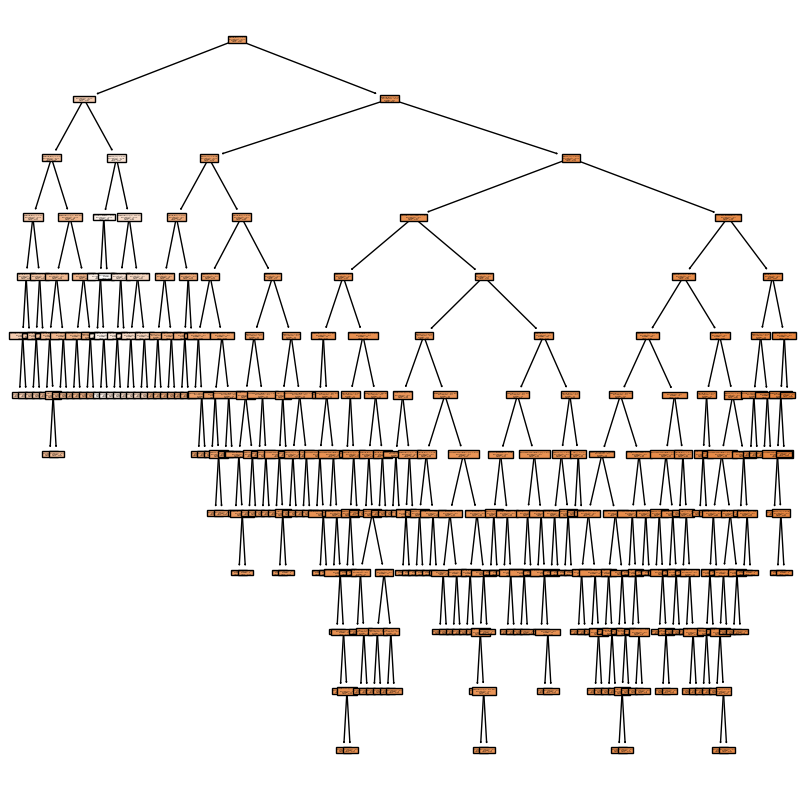

In [ ]:
plt.figure(figsize=(10,10))
_ = tree.plot_tree(rf_best_estimator.estimators_[0], feature_names=df_X_fs.columns, filled=True)

In [ ]:
rf_best_estimator.feature_importances_

array([2.29667667e-05, 2.27092092e-02, 1.24257566e-02, 3.29823081e-04,
       2.53424136e-01, 3.20294725e-01, 6.61376514e-02, 9.98089674e-03,
       3.36149001e-05, 3.13797197e-02, 1.54186304e-04, 4.06005991e-04,
       2.82701308e-01])

<Axes: >

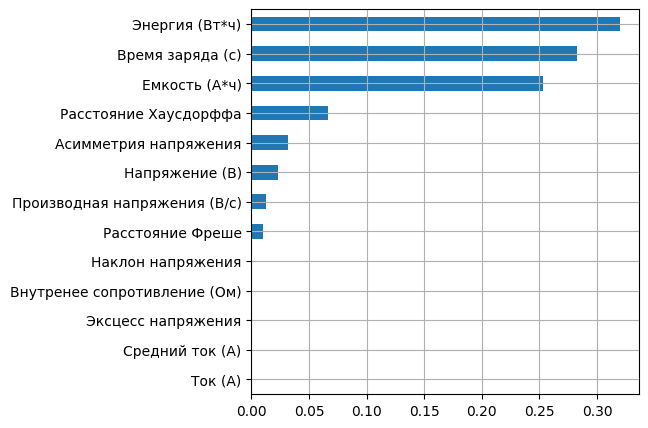

In [ ]:
# Проверка ошибки на кросс-валидации и feature_importances
# cv = KFold(n_splits=5, shuffle=True, random_state=1)
# scores = cross_val_score(estimator=rf_best_estimator, X=X_fs, y=y_fs, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

pd.DataFrame(data={'score': rf_best_estimator.feature_importances_},
                      index=df_X_fs.columns).sort_values(by='score').plot(kind='barh', grid=True, figsize=(5,5), legend=False)

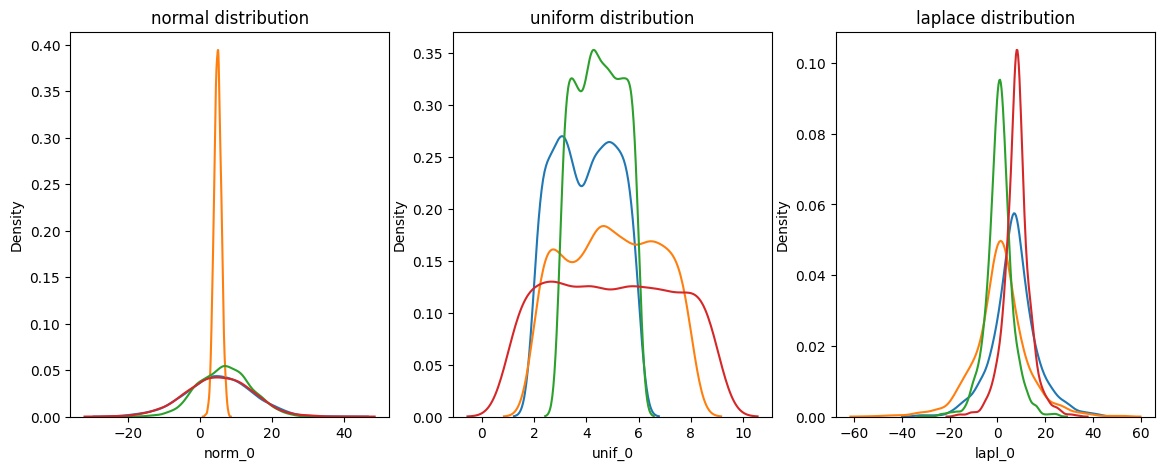

In [ ]:
# Для проверки того, что rf не переобучен, сделаем зашумленные данные:
# Создадим 12 шумовых признаков, элементами которых будут некоррелируемые случайные числа из выборок с нормальным, равномерным и Лапласовым распределениями.
# Параметры каждого распределения подбираются случайным образом независимо друг от друга.
# Далее также построим оценку кросс-валидации на этих данных и feature_importances
# утановим значение генератора случайных чисел для воспроизводимости
np.random.seed(1)

fix, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
ax1.set_title("normal distribution")
ax2.set_title("uniform distribution")
ax3.set_title("laplace distribution")
for i in range(4):
    df_X_fs.loc[:, f'norm_{i}'] = np.random.normal(loc=np.random.randint(low=0, high=10),
                                             scale=np.random.randint(low=1, high=10),
                                             size=(df_X_fs.shape[0], 1))

    df_X_fs.loc[:, f'unif_{i}'] = np.random.uniform(low=np.random.randint(low=1, high=4),
                                              high=np.random.randint(low=5, high=10),
                                              size=(df_X_fs.shape[0], 1))
    df_X_fs.loc[:, f'lapl_{i}'] = np.random.laplace(loc=np.random.randint(low=0, high=10),
                                              scale=np.random.randint(low=1, high=10),
                                              size=(df_X_fs.shape[0], 1))
    # визуализируем распределения признаков
    sns.kdeplot(df_X_fs[f'norm_{i}'], ax=ax1)
    sns.kdeplot(df_X_fs[f'unif_{i}'], ax=ax2)
    sns.kdeplot(df_X_fs[f'lapl_{i}'], ax=ax3)

In [ ]:
# Преобучение RF на зашумленных данных
rf_noise_data = rf_best_estimator.fit(df_X_fs, df_y_fs)

model_save_name = 'rf_for_RFECV_noise_data_new_CS.bin'
folder_path = '/content/drive/MyDrive/Battery_project/RF_for_RFECV_CC_step'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(rf_noise_data, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/RF_for_RFECV_СС_step

cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/RF_for_RFECV_CC_step'
pickle_file_path = os.path.join(pickle_file_folder, 'rf_for_RFECV_noise_data_new_CS.bin')
rf_noise_data = pd.read_pickle(pickle_file_path)

In [ ]:
rf_noise_data.feature_importances_

array([3.64420098e-04, 7.85244772e-02, 4.37597976e-02, 1.83935294e-02,
       2.06110493e-01, 1.95361482e-01, 1.06408389e-01, 3.58141142e-02,
       7.32810420e-04, 7.87803454e-02, 1.85623157e-02, 9.13535839e-03,
       2.07704504e-01, 3.36997797e-05, 1.50187021e-05, 2.19614208e-05,
       2.42674760e-05, 5.68708333e-05, 2.69610338e-05, 2.05371043e-05,
       3.78148428e-05, 4.28053454e-05, 2.64198200e-05, 2.69902265e-05,
       1.46164376e-05])

<Axes: >

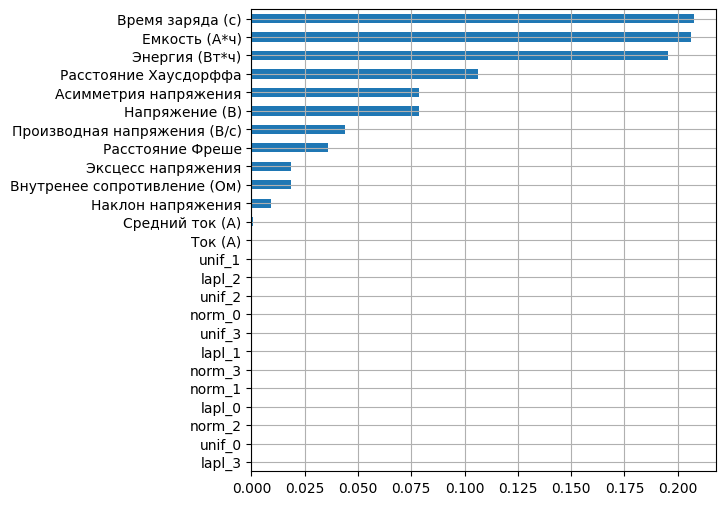

In [ ]:
# Проверка ошибки на кросс-валидации и feature_importances зашумленных данных
# cv = KFold(n_splits=5, shuffle=True, random_state=1)
# scores = cross_val_score(estimator=rf_noise_data, X=df_X_fs, y=df_y_fs, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

pd.DataFrame(data={'score': rf_noise_data.feature_importances_},
                      index=df_X_fs.columns).sort_values(by='score').plot(kind='barh', grid=True, figsize=(6,6), legend=False)

# **RFECV with RF.best_estimator_**

In [ ]:
min_features_to_select = 2

In [ ]:
rfe_cv = RFECV(estimator=rf_best_estimator, min_features_to_select=min_features_to_select, cv=group_kfold, step=1,
                   scoring='neg_mean_squared_error', verbose=2, n_jobs=None)

In [ ]:
rfe_cv.fit(X_fs, y_fs, groups=groups)

model_save_name = 'rfecv_CC_step_new_for_5_batteries_train.bin'
folder_path = '/content/drive/MyDrive/Battery_project/RFECV_CC_step'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(rfe_cv, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/rfecv_СС_step

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting 

In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/RFECV_CC_step'
pickle_file_path = os.path.join(pickle_file_folder, 'rfecv_CC_step_new_for_5_batteries_train.bin')
rfe_cv = pd.read_pickle(pickle_file_path)
rfe_cv.n_features_

11

In [ ]:
# Возвращаемся к данным без шумов в df_X_fs
df_X_fs = data_fs.drop(columns=['SOH', 'Cycle_Index', 'Group'])
df_y_fs = data_fs['SOH']

All features:  Index(['Ток (А)', 'Напряжение (В)', 'Производная напряжения (В/с)',
       'Внутренее сопротивление (Ом)', 'Емкость (А*ч)', 'Энергия (Вт*ч)',
       'Расстояние Хаусдорффа', 'Расстояние Фреше', 'Средний ток (А)',
       'Асимметрия напряжения', 'Эксцесс напряжения', 'Наклон напряжения',
       'Время заряда (с)'],
      dtype='object')
Selected features:  [False  True  True  True  True  True  True  True False  True  True  True
  True]
Number of selected features:  11
Cross-validation results:  {'mean_test_score': array([-1.14915732e-04, -1.16098732e-04, -1.11847620e-04, -1.08951007e-04,
       -1.01292979e-04, -1.00477092e-04, -9.77394815e-05, -9.16998190e-05,
       -8.74270597e-05, -8.38349866e-05, -8.57446907e-05, -8.98541390e-05]), 'std_test_score': array([4.66753077e-05, 4.42610877e-05, 4.42527872e-05, 4.19352007e-05,
       3.01053025e-05, 3.27849417e-05, 2.91028750e-05, 2.82859407e-05,
       3.90374604e-05, 4.16180618e-05, 3.96818844e-05, 3.91129808e-05]), 'split

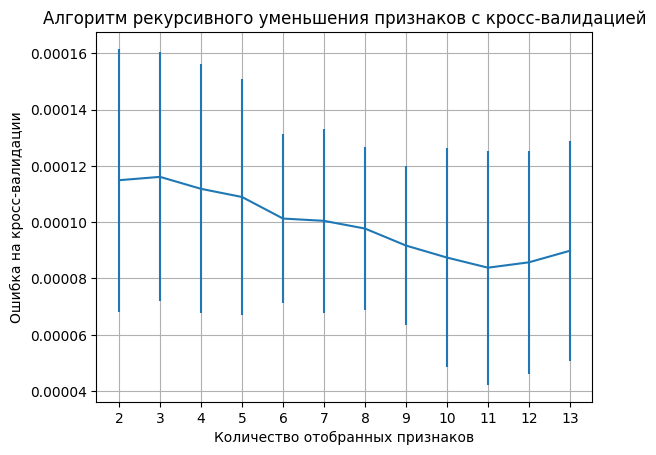

In [ ]:
print("All features: " , df_X_fs.columns)
print("Selected features: ", rfe_cv.support_)
print("Number of selected features: ", rfe_cv.n_features_)
print("Cross-validation results: ", rfe_cv.cv_results_)
# List of features
for i in range(X_fs.shape[1]):
  print(f'Column: {i}, Selected {rfe_cv.support_[i]}, Rank: {rfe_cv.ranking_[i]}')
# Plot
n_scores = len(rfe_cv.cv_results_["mean_test_score"])
errors = -rfe_cv.cv_results_["mean_test_score"]
plt.figure()
plt.xlabel("Количество отобранных признаков")
plt.ylabel("Ошибка на кросс-валидации")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    errors,
    yerr=rfe_cv.cv_results_["std_test_score"],
)
plt.title("Алгоритм рекурсивного уменьшения признаков с кросс-валидацией")
plt.xticks(np.arange(2, n_scores + min_features_to_select, 1))
plt.grid()
plt.show()
# Чем neg_mean_squared_error ближе к 0, тем лучше

array([2.82903160e-05, 3.08218738e-02, 1.04956500e-02, 4.76712692e-04,
       2.39297361e-01, 2.88645473e-01, 5.59110076e-02, 1.24175159e-02,
       2.87168320e-05, 5.61939211e-02, 2.29263298e-04, 3.41712878e-04,
       3.05112502e-01])

In [ ]:
rfe_cv.estimator_.feature_importances_

array([2.14950398e-02, 9.38025936e-03, 4.02727058e-04, 3.17106099e-01,
       2.55501688e-01, 4.86485660e-02, 9.13342749e-03, 2.54368764e-02,
       9.42879905e-05, 3.61660860e-04, 3.12439367e-01])

# **Select features with SelectKBest**

In [ ]:
# Возвращаемся к данным без шумов в df_X_fs
df_X_fs = data_fs.drop(columns=['SOH', 'Cycle_Index', 'Group'])
df_y_fs = data_fs['SOH']
X_fs = np.array(df_X_fs)
y_fs = np.array(df_y_fs).reshape(-1)
df_X_fs.columns

Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)',
       'Capacity_Ah', 'Energy_Wh', 'Hausdorff_distance', 'Frechet_distance',
       'Signal_mean', 'Skewness', 'Kurtosis', 'Slope', 'Charge_Time_s'],
      dtype='object')

In [ ]:
select_k_best = GenericUnivariateSelect(score_func=mutual_info_regression, mode = 'k_best', param = 'all')
select_k_best.fit(X_fs, y_fs)
# выведем результаты оценки каждого признака
pd.DataFrame(data={'score':select_k_best.scores_,
                   'support':select_k_best.get_support()},
             index=df_X_fs.columns).sort_values(by='score',ascending=False)

,score,support
Capacity_Ah,5.766570,True
Energy_Wh,4.132823,True
Charge_Time_s,3.882800,True
Skewness,2.279156,True
Hausdorff_distance,2.151314,True
Voltage(V),1.877901,True
Slope,1.393302,True
dV/dt(V/s),1.367074,True
Kurtosis,1.287864,True
Internal_Resistance(Ohm),1.210056,True


### **Узнаем, при каком количестве параметров получается лучшая точность (меньшая ошибка модели) - произведем поиск количества параметров 'param' SelectKBest**

In [ ]:
# В пайпланйе - Rf и select_k_best вместе
pipeline = Pipeline([('rf', rf), ('selector', select_k_best)])
cv = KFold(n_splits=5, shuffle=True, random_state=1)

params = {"selector__param": np.arange(3,12),
          "rf__max_depth": [5, 10, 15, 20, 25],  # 15-25, 5-10
          "rf__max_features": [2, 3, 4, 5, 6],
          "rf__min_samples_split": [2, 3, 4, 5],
          "rf__min_samples_leaf": [5, 7, 10, 12, 15],
          "rf__criterion": ['squared_error']}

rf_select_k_best_gs = GridSearchCV(estimator=pipeline, param_grid=group_kfold, cv=group_kfold, n_jobs=-1, verbose=2, refit=True, scoring='neg_mean_squared_error')
rf_select_k_best_gs.fit(X_fs, y_fs)

model_save_name = 'rf_selectkbest.bin'
folder_path = '/content/drive/MyDrive/Battery_project/RFECV_CC_step'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(rf_select_k_best_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/rfecv_СС_step

# **Transform data for a prediction model according to the features selected**

In [ ]:
data_test = pd.DataFrame()
n = 1
for file in range(len(test_filenames_CS)):
  data = pd.read_csv(os.path.join(filenames_folder, test_filenames_CS[file]), index_col=None)
  data = data.assign(Group=n).dropna()
  data_test = pd.concat([data_test, data], axis=0)
  n+=1
# data_test.columns

In [ ]:
groups_data_test = len(data_test.Group.unique())
groups_data_test

1

In [ ]:
data_test_opt_no_of_feat_X = pd.DataFrame(rfe_cv.transform(data_test.drop(columns=['Cycle_Index','Group', 'SOH'])))
data_test_opt_no_of_feat_X = data_test_opt_no_of_feat_X.reset_index(drop=True)
data_test_y = data_test['SOH']
data_test_y = data_test_y.reset_index(drop=True)
data_test_transformed = pd.concat([data_test_opt_no_of_feat_X, data_test_y], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [ ]:
df_X_test = data_test_transformed.drop(columns=['SOH'])
df_y_test = data_test_transformed['SOH']
X_test = np.array(df_X_test)
y_test = np.array(df_y_test).reshape(-1)

In [ ]:
data_train = pd.DataFrame()
n = 1
for file in range(len(train_filenames_CS)):
  data = pd.read_csv(os.path.join(filenames_folder, train_filenames_CS[file]), index_col=None)
  data = data.assign(Group=n).dropna()
  data_train = pd.concat([data_train, data], axis=0)
  n+=1
# data_train.columns

In [ ]:
groups_data_train = len(data_train.Group.unique())
groups_data_train

5

In [ ]:
data_train_opt_no_of_feat_X = pd.DataFrame(rfe_cv.transform(data_train.drop(columns=['Cycle_Index','Group', 'SOH'])))
data_train_opt_no_of_feat_X = data_train_opt_no_of_feat_X.reset_index(drop=True)
data_train_y = data_train['SOH']
data_train_y = data_train_y.reset_index(drop=True)
data_train_transformed = pd.concat([data_train_opt_no_of_feat_X, data_train_y], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [ ]:
df_X_train = data_train_transformed.drop(columns=['SOH'])
df_y_train = data_train_transformed['SOH']
X_train = np.array(df_X_train)
y_train = np.array(df_y_train).reshape(-1)
df_X_train.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='object')

In [ ]:
# Check train and test data ratio
print(float(df_X_train.shape[0] / df_X_test.shape[0]))

5.933712121212121


In [ ]:
# Uncleaned test data
data_test_uncleaned = pd.DataFrame()
n = 1
for file in range(len(test_filenames_uncleaned_CS)):
  data = pd.read_csv(os.path.join(filenames_folder_uncleaned, test_filenames_uncleaned_CS[file]), index_col=None)
  data = data.assign(Group=n).dropna()
  data_test_uncleaned = pd.concat([data_test_uncleaned, data], axis=0)
  n+=1
# data_test_uncleaned.columns

In [ ]:
data_test_uncleaned_opt_no_of_feat_X = pd.DataFrame(rfe_cv.transform(data_test_uncleaned.drop(columns=['Unnamed: 0','Cycle_Index','Group', 'SOH']))).reset_index(drop=True)
data_test_uncleaned_y = data_test_uncleaned['SOH'].reset_index(drop=True)
data_test_uncleaned_transformed = pd.concat([data_test_uncleaned_opt_no_of_feat_X, data_test_uncleaned_y], axis=1)
# data_test_uncleaned_transformed.columns

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [ ]:
df_X_test_uncleaned = data_test_uncleaned_transformed.drop(columns=['SOH'])
df_y_test_uncleaned = data_test_uncleaned_transformed['SOH']
X_test_uncleaned = np.array(df_X_test_uncleaned)
y_test_uncleaned = np.array(df_y_test_uncleaned).reshape(-1)
# df_X_test_uncleaned.columns

In [ ]:
# New battery data - CX
data_train_new = pd.DataFrame()
n = 1
for file in range(len(train_filenames_CX)):
  data = pd.read_csv(os.path.join(filenames_folder, train_filenames_CX[file]), index_col=None)
  data = data.assign(Group=n).dropna()
  data_train_new = pd.concat([data_train_new, data], axis=0)
  n+=1
# data_train_new.columns

In [ ]:
data_train_new_opt_no_of_feat_X = pd.DataFrame(rfe_cv.transform(data_train_new.drop(columns=['Cycle_Index','Group', 'SOH']))).reset_index(drop=True)
data_train_new_y = data_train_new['SOH'].reset_index(drop=True)
data_train_new_transformed = pd.concat([data_train_new_opt_no_of_feat_X, data_train_new_y], axis=1)
# data_train_new_transformed.columns

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [ ]:
df_X_train_new = data_train_new_transformed.drop(columns=['SOH'])
df_y_train_new = data_train_new_transformed['SOH']
X_train_new = np.array(df_X_train_new)
y_train_new = np.array(df_y_train_new).reshape(-1)
# df_X_train_new.columns

In [ ]:
data_test_new = pd.DataFrame()
n = 1
for file in range(len(test_filenames_CX)):
  data = pd.read_csv(os.path.join(filenames_folder, test_filenames_CX[file]), index_col=None)
  data = data.assign(Group=n).dropna()
  data_test_new = pd.concat([data_test_new, data], axis=0)
  n+=1
# data_test_new.columns

In [ ]:
data_test_new_opt_no_of_feat_X = pd.DataFrame(rfe_cv.transform(data_test_new.drop(columns=['Cycle_Index','Group', 'SOH']))).reset_index(drop=True)
data_test_new_y = data_test_new['SOH'].reset_index(drop=True)
data_test_new_transformed = pd.concat([data_test_new_opt_no_of_feat_X, data_test_new_y], axis=1)
# data_test_new_transformed.columns

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [ ]:
df_X_test_new = data_test_new_transformed.drop(columns=['SOH'])
df_y_test_new = data_test_new_transformed['SOH']
X_test_new = np.array(df_X_test_new)
y_test_new = np.array(df_y_test_new).reshape(-1)
# df_X_test_new.columns

In [ ]:
# Check train and test data ratio
print(float(df_X_train_new.shape[0] / df_X_test_new.shape[0]))

5.149015932521087


# **Make prediction with Random Forest**

In [ ]:
rf_for_predict = RandomForestRegressor(n_estimators=300, bootstrap=True, n_jobs=None)

In [ ]:
no_of_splits_predict = groups_data_train
groups_predict = data_train.Group
group_kfold_predict = GroupKFold(n_splits=no_of_splits_predict)

In [ ]:
no_of_splits_predict

7

In [ ]:
max_no_of_features = min(len(df_X_train.columns), 10)
max_no_of_features

10

In [ ]:
len(df_X_train.columns)

12

In [ ]:
params= {"max_depth": [5, 10, 15, 20, 25],  # 15-25, 5-10
                   "max_features": list(range(3, max_no_of_features, 1)),
                   "min_samples_split": [2, 3, 4, 5],
                   "min_samples_leaf": [5, 7, 10, 12, 15],
                   "criterion": ['squared_error']}

In [ ]:
rf_search_predict = GridSearchCV(estimator=rf_for_predict, param_grid=params, cv=group_kfold_predict, n_jobs=-1, verbose=2, refit=True)

In [ ]:
rf_search_predict.fit(X_train, y_train, groups=groups_predict)

model_save_name = 'rf_predict.bin'
folder_path = '/content/drive/MyDrive/Battery_project/RF_for_prediction'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(rf_search_predict, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/rf_predict

Fitting 7 folds for each of 700 candidates, totalling 4900 fits


KeyboardInterrupt: 

In [ ]:
# для понимания того, что модель не переобучилась
y_pred = rfe_cv.predict(X_test)
loss = np.sqrt(np.mean(np.square(((y_test - y_pred) / y_test)), axis=0))
print(loss)

0.0525775467769295


# **Make prediction with Gradient Boosting**

In [ ]:
gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10
)

In [ ]:
gb.fit(X_train, y_train)
gb_mse = mean_squared_error(y_train, gb.predict(X_train), squared=False)
print(f"GB MSE:{gb_mse:.15f}")

GB MSE:0.000042706794473


In [ ]:
gb.score(X_test, y_test) # R2 score

0.9824190032021144

In [ ]:
gb_params = {'max_depth': [1, 2, 3, 4, 5],
    'n_estimators': [10, 100, 200]}

In [ ]:
# Evaluate model score by cross-validation
no_of_splits = len(np.unique(data_train.Group))
groups = data_train.Group
group_kfold = GroupKFold(n_splits=no_of_splits)
no_of_splits

5

In [ ]:
gb_gs = GridSearchCV(estimator = gb, param_grid = gb_params, cv = group_kfold, n_jobs = -1, verbose = 4)

In [ ]:
gb_gs.fit(X_train, y_train, groups = groups)

model_save_name = 'gb_new_for_5_batteries_train.bin'
folder_path = '/content/drive/MyDrive/Battery_project/Gradient_boost'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(gb_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/Gradient_boost

Fitting 5 folds for each of 15 candidates, totalling 75 fits
cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/Gradient_boost'
pickle_file_path = os.path.join(pickle_file_folder, 'gb_new_for_5_batteries_train.bin')
gb_gs = pd.read_pickle(pickle_file_path)

In [ ]:
gb_best_estimator = gb_gs.best_estimator_
gb_best_parameters = gb_gs.best_params_

Соответствия features:  0 - 'Voltage(V)',
1 -'dV/dt(V/s)',
2 -'Internal_Resistance(Ohm)',
3 -'Capacity_Ah',
4 -'Energy_Wh',
5 -'Hausdorff_distance',
6 -'Frechet_distance',
7 -'Skewness',
8 -'Kurtosis',
9 -'Slope',
10 -'Charge_Time_s'

<Axes: >

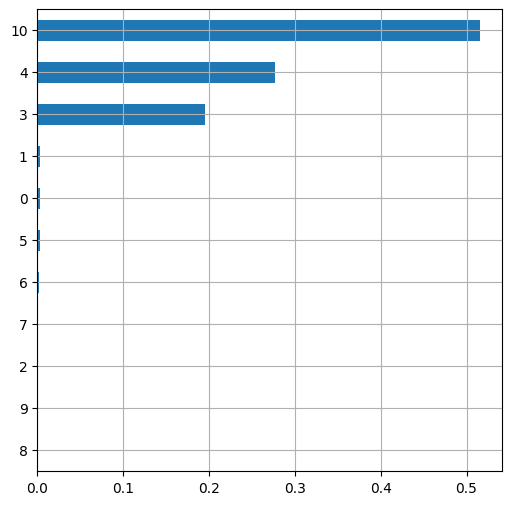

In [ ]:
# Проверка ошибки на кросс-валидации и feature_importances
# cv = KFold(n_splits=5, shuffle=True, random_state=1)
# scores = cross_val_score(estimator=gb_best_estimator, X=df_X_train, y=df_y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

pd.DataFrame(data={'score': gb_best_estimator.feature_importances_},
                      index=df_X_train.columns).sort_values(by='score').plot(kind='barh', grid=True, figsize=(6,6), legend=False)

In [ ]:
# Predict for train data (cleaned, predict of model itself)
print('Наилучший результат: %0.3f' % gb_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_best_parameters[param_name]))

y_pred = gb_best_estimator.predict(X_train)

print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))

Наилучший результат: 0.999
Наилучшие параметры: 
	max_depth: 4
	n_estimators: 100
Best GB MSE for train data 1.9409940506172244e-06


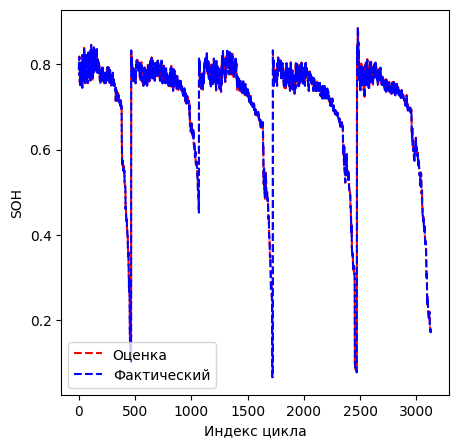

In [ ]:
# Visualize y_pred and y_train
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_train, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Predict for train data (cleaned, predict of model itself)
y_pred = gb.predict(X_train)
print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))

Best GB MSE for train data 1.823870294171331e-09


In [ ]:
# Predict for test data (cleaned)
gb_best_estimator = gb_gs.best_estimator_
gb_best_parameters = gb_gs.best_params_
print('Наилучший результат: %0.3f' % gb_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_best_parameters[param_name]))

y_pred = gb_best_estimator.predict(X_test)

print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))

Наилучший результат: 0.999
Наилучшие параметры: 
	max_depth: 4
	n_estimators: 100
Best GB MSE for test data 0.00031414011583854516


In [ ]:
# Predict for test data (cleaned)
y_pred = gb.predict(X_test)
print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))

Best GB MSE for test data 0.0003837609765870674


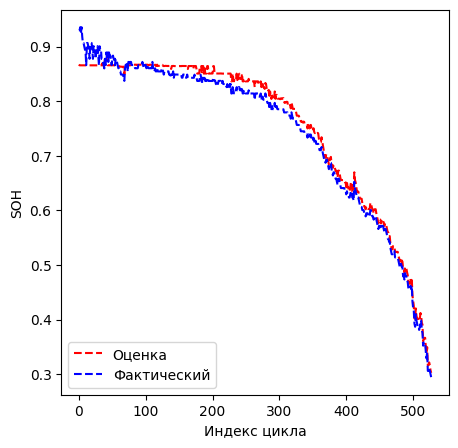

In [ ]:
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

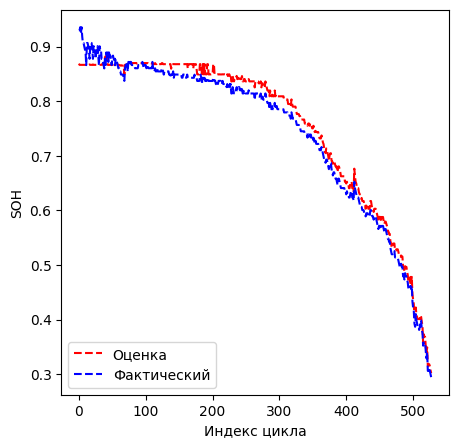

In [ ]:
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Print 20 worst predicts for test data
samples = range(20)
X_test_samples = [X_test[i] for i in samples]
y_test_samples = [y_test[i] for i in samples]
y_pred_samples = gb_best_estimator.predict(X_test_samples)

# print(len(y_test_samples), len(y_pred_samples))
a = [(y_pred_samples[i], y_test_samples[i], abs(y_pred_samples[i]-y_test_samples[i])) for i in range(len(samples))]
b = sorted(a, key=lambda x: x[2], reverse=True)
for i in range(20):
  print(b[i])
# for i in range(len(y_pred_samples)):
#   # print(y_test_samples[i], y_pred_samples[i])
#   print(f'{y_test_samples[i]:.3f}', f'{y_pred_samples[i]:.3f}')
print(max(y_pred_samples))

(0.8657010726806643, 0.9354795123538668, 0.06977843967320252)
(0.8657010726806643, 0.9354560622201594, 0.0697549895394951)
(0.8657010726806643, 0.9296744283994826, 0.06397335571881824)
(0.8671841462538444, 0.9295937535702308, 0.06240960731638634)
(0.8657010726806643, 0.9238964713885284, 0.058195398707864054)
(0.8657866082234464, 0.9180602468100528, 0.052273638586606386)
(0.8657010726806643, 0.9065982642179254, 0.040897191537261124)
(0.8657469448072997, 0.9066160633146004, 0.040869118507300684)
(0.8657866082234464, 0.9066125275746312, 0.040825919351184736)
(0.8657866082234464, 0.9065871747203412, 0.040800566496894786)
(0.8657469448072997, 0.9065095430326175, 0.0407625982253178)
(0.8657469448072997, 0.9064751086464092, 0.04072816383910949)
(0.8656691361886744, 0.900862290648444, 0.03519315445976967)
(0.8657469448072997, 0.9008631338750244, 0.035116189067724624)
(0.8657589834590202, 0.9007175754266952, 0.034958591967674923)
(0.8657589834590202, 0.894960139379498, 0.029201155920477784)
(0.

In [ ]:
# Predict for uncleaned test data
print('Наилучший результат: %0.3f' % gb_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_best_parameters[param_name]))

y_pred = gb_best_estimator.predict(X_test_uncleaned)

print('Best GB MSE for test uncleaned data ' + str(mean_squared_error(y_test_uncleaned, y_pred)))

Наилучший результат: 0.999
Наилучшие параметры: 
	max_depth: 4
	n_estimators: 100
Best GB MSE for test uncleaned data 0.00034290966809907267


In [ ]:
# Predict for uncleaned test data
y_pred = gb.predict(X_test_uncleaned)
print('Best GB MSE for test uncleaned data ' + str(mean_squared_error(y_test_uncleaned, y_pred)))

Best GB MSE for test uncleaned data 0.00040989570186896433


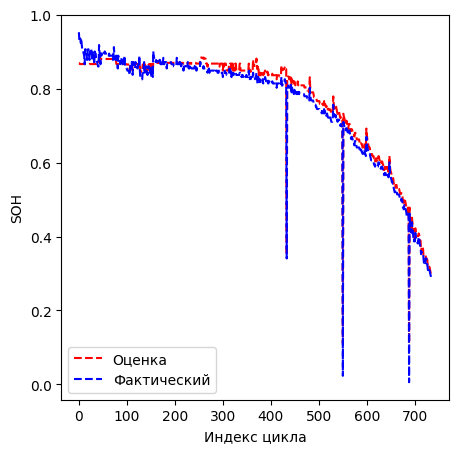

In [ ]:
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test_uncleaned, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Refit gb on new data
gb_best_estimator.fit(X_train_new, y_train_new)

GradientBoostingRegressor(max_depth=4)

In [ ]:
# Predict for new battery data for train part (predict itself)
print('Наилучший результат: %0.3f' % gb_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_best_parameters[param_name]))

y_pred = gb_best_estimator.predict(X_train_new)

print('Best GB MSE for train part of new data ' + str(mean_squared_error(y_train_new, y_pred)))

Наилучший результат: 0.999
Наилучшие параметры: 
	max_depth: 4
	n_estimators: 100
Best GB MSE for train part of new data 0.008307506960068328


In [ ]:
# Predict for new battery data for test part
y_pred = gb_best_estimator.predict(X_test_new)
print('Best GB MSE for test part of new data ' + str(mean_squared_error(y_test_new, y_pred)))

Best GB MSE for test part of new data 0.0027978962400267687


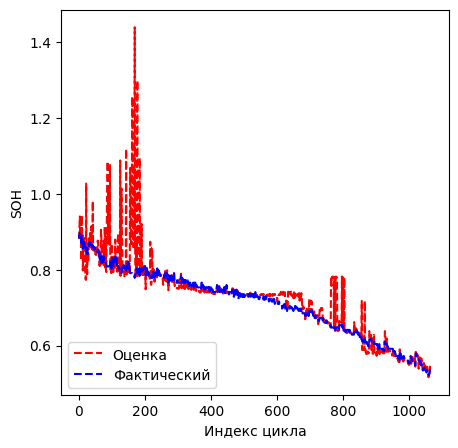

In [ ]:
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test_new, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

# **Make prediction with a pipeline RFECV(RF.best_estimator_) -> Gradient Boosting**

In [ ]:
pipeline = Pipeline(steps=[('selector', rfe_cv),('model', gb_best_estimator)])

In [ ]:
pipeline.fit(X_train, y_train, selector__groups=groups)

ValueError: Found input variables with inconsistent numbers of samples: [2530, 2530, 1467]

In [ ]:
y_pred = pipeline.predict(X_train)
print('Best Pipeline MSE for train data ' + str(mean_squared_error(y_train, y_pred)))

In [ ]:
y_pred = pipeline.predict(X_test)
print('Best Pipeline MSE for test data ' + str(mean_squared_error(y_test, y_pred)))

In [ ]:
# y_pred = pipeline.predict(X_new)
# print('Best Pipeline MSE for new data ' + str(mean_squared_error(y_new, y_pred)))

# **Predict for top 5 features**

Соответствия features:  0 - 'Voltage(V)',
1 -'dV/dt(V/s)',
2 -'Internal_Resistance(Ohm)',
3 -'Capacity_Ah',
4 -'Energy_Wh',
5 -'Hausdorff_distance',
6 -'Frechet_distance',
7 -'Skewness',
8 -'Kurtosis',
9 -'Slope',
10 -'Charge_Time_s'

Feature rank by gradient boosting: 4, 10, 3, 5, 1, 0, 7, 6, 2, 9, 8

In [ ]:
top_5 = [4, 10, 3, 5, 7]
df_X_train_top_5 = df_X_train.drop(columns=[0, 2, 6, 1, 8, 9])
X_train_top_5 = np.array(df_X_train_top_5)

In [ ]:
gb_top_5 = gb
gb_top_5.fit(df_X_train_top_5, y_train)
gb_top_5_mse = mean_squared_error(y_train, gb_top_5.predict(X_train_top_5), squared=False)
print(f"GB MSE for best features:{gb_top_5_mse:.15f}")

GB MSE for best features:0.000327833216108


In [ ]:
gb_params = {'max_depth': [1, 2, 3, 4, 5],
'n_estimators': [10, 100, 200]}

In [ ]:
no_of_splits = groups_data_train
groups = data_train.Group
group_kfold = GroupKFold(n_splits=no_of_splits)
no_of_splits

NameError: name 'groups_data_train' is not defined

In [ ]:
gb_top_5_gs = GridSearchCV(estimator = gb_top_5, param_grid = gb_params, cv = group_kfold, n_jobs = -1, verbose = 4)

In [ ]:
gb_top_5_gs.fit(df_X_train_top_5, y_train, groups = groups)

model_save_name = 'gb_top_5_CS.bin'
folder_path = '/content/drive/MyDrive/Battery_project/Gradient_boost'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(gb_top_5_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/Gradient_boost

Fitting 5 folds for each of 15 candidates, totalling 75 fits
cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/Gradient_boost'
pickle_file_path = os.path.join(pickle_file_folder, 'gb_top_5_CS.bin')
gb_top_5_gs = pd.read_pickle(pickle_file_path)

In [ ]:
gb_top_5_best_estimator = gb_top_5_gs.best_estimator_
gb_top_5_best_parameters = gb_top_5_gs.best_params_
gb_top_5_best_parameters

{'max_depth': 4, 'n_estimators': 100}

In [ ]:
# Predict for train data (predict itself)
print('Наилучший результат: %0.3f' % gb_top_5_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_top_5_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_top_5_best_parameters[param_name]))

y_pred = gb_top_5_best_estimator.predict(X_train_top_5)

print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))

Наилучший результат: 0.998
Наилучшие параметры: 
	max_depth: 4
	n_estimators: 100
Best GB MSE for train data 5.089607864079649e-06


In [ ]:
df_X_test_top_5 = df_X_test.drop(columns=[0, 2, 6, 1, 8, 9])
X_test_top_5 = np.array(df_X_test_top_5)

In [ ]:
# Predict for test data (cleaned)
y_pred = gb_top_5_best_estimator.predict(X_test_top_5)
print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))

Best GB MSE for test data 0.0003657039865610944


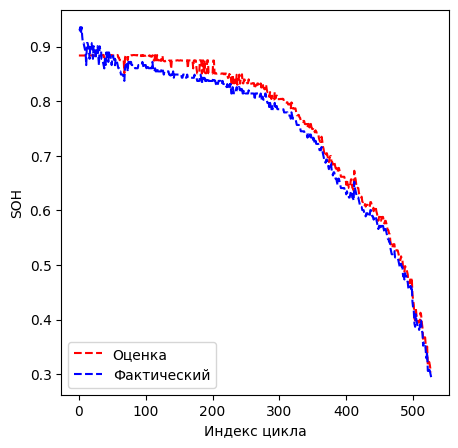

In [ ]:
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

In [ ]:
samples = range(20)
X_test_top_5_samples = [X_test_top_5[i] for i in samples]
y_test_samples = [y_test[i] for i in samples]
y_pred_samples = gb_top_5_best_estimator.predict(X_test_top_5)

# print(len(y_test_samples), len(y_pred_samples))
a = [(y_pred_samples[i], y_test_samples[i], abs(y_pred_samples[i]-y_test_samples[i])) for i in range(len(samples))]
b = sorted(a, key=lambda x: x[2], reverse=True)
for i in range(20):
  print(b[i])
# for i in range(len(y_pred_samples)):
#   # print(y_test_samples[i], y_pred_samples[i])
#   print(f'{y_test_samples[i]:.3f}', f'{y_pred_samples[i]:.3f}')

(0.8849590772216751, 0.9354795123538668, 0.05052043513219173)
(0.8849590772216751, 0.9354560622201594, 0.05049698499848432)
(0.8849590772216751, 0.9296744283994826, 0.04471535117780745)
(0.8849590772216751, 0.9295937535702308, 0.04463467634855567)
(0.8849590772216751, 0.9238964713885284, 0.03893739416685327)
(0.8849590772216751, 0.9180602468100528, 0.03310116958837772)
(0.8849590772216751, 0.9066160633146004, 0.021656986092925323)
(0.8849590772216751, 0.9066125275746312, 0.021653450352956072)
(0.8849590772216751, 0.9065982642179254, 0.021639186996250337)
(0.8849590772216751, 0.9065871747203412, 0.02162809749866612)
(0.8849590772216751, 0.9065095430326175, 0.021550465810942443)
(0.8849590772216751, 0.9064751086464092, 0.021516031424734128)
(0.8849590772216751, 0.866080620218177, 0.018878457003498106)
(0.8836766841168826, 0.900862290648444, 0.017185606531561426)
(0.8849590772216751, 0.9008631338750244, 0.015904056653349263)
(0.8849590772216751, 0.9007175754266952, 0.015758498205020066)
(

# **Predict for top 7 features**

Соответствия features: 0 - 'Voltage(V)', 1 -'dV/dt(V/s)', 2 -'Internal_Resistance(Ohm)', 3 -'Capacity_Ah', 4 -'Energy_Wh', 5 -'Hausdorff_distance', 6 -'Frechet_distance', 7 -'Skewness', 8 -'Kurtosis', 9 -'Slope', 10 -'Charge_Time_s'

Feature rank by gradient boosting: 4, 10, 3, 5, 1, 0, 7, 6, 2, 9, 8

In [ ]:
top_7 = [4, 10, 3, 5, 0, 7, 1]
df_X_train_top_7 = df_X_train.drop(columns=[2, 6, 8, 9])
X_train_top_7 = np.array(df_X_train_top_7)
df_X_train_top_7.columns

Index([0, 1, 3, 4, 5, 7, 10], dtype='object')

In [ ]:
gb_top_7 = gb
gb_top_7.fit(df_X_train_top_7, y_train)
gb_top_7_mse = mean_squared_error(y_train, gb_top_7.predict(X_train_top_7), squared=False)
print(f"GB MSE for best features:{gb_top_7_mse:.15f}")

GB MSE for best features:0.000278248053483


In [ ]:
gb_top_7_gs = GridSearchCV(estimator = gb_top_7, param_grid = gb_params, cv = group_kfold, n_jobs = -1, verbose = 4)

In [ ]:
gb_top_7_gs.fit(df_X_train_top_7, y_train, groups = groups)

model_save_name = 'gb_top_7_CS.bin'
folder_path = '/content/drive/MyDrive/Battery_project/Gradient_boost'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(gb_top_7_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/Gradient_boost

Fitting 5 folds for each of 24 candidates, totalling 120 fits
cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/Gradient_boost'
pickle_file_path = os.path.join(pickle_file_folder, 'gb_top_7_CS.bin')
gb_top_7_gs = pd.read_pickle(pickle_file_path)

In [ ]:
gb_top_7_best_estimator = gb_top_7_gs.best_estimator_
gb_top_7_best_parameters = gb_top_7_gs.best_params_
gb_top_7_best_parameters

{'max_depth': 4, 'n_estimators': 100}

In [ ]:
# Проверка ошибки на кросс-валидации
# cv = KFold(n_splits=5, shuffle=True, random_state=1)
# scores = cross_val_score(estimator=gb_top_7_best_estimator, X=df_X_train_top_7, y=df_y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

Наилучший результат: 0.998
Наилучшие параметры: 
	max_depth: 4
	n_estimators: 100
Best GB MSE for train data 4.855044062695222e-06


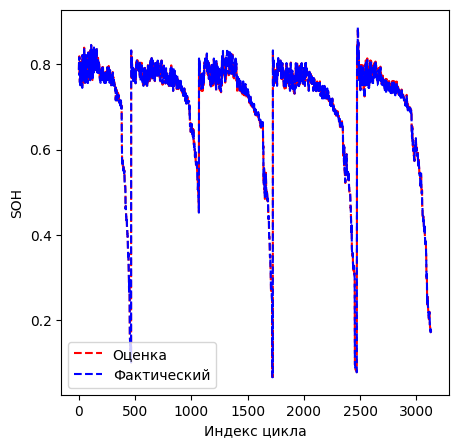

In [ ]:
# Predict for train data (predict itself)
print('Наилучший результат: %0.3f' % gb_top_7_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_top_7_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_top_7_best_parameters[param_name]))

y_pred = gb_top_7_best_estimator.predict(X_train_top_7)
print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))

# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_train, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

In [ ]:
df_X_test_top_7 = df_X_test.drop(columns=[2, 6, 8, 9])
X_test_top_7 = np.array(df_X_test_top_7)

In [ ]:
# Predict for test data (cleaned)
y_pred = gb_top_7_best_estimator.predict(X_test_top_7)
print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))

Best GB MSE for test data 0.0002022748096470078


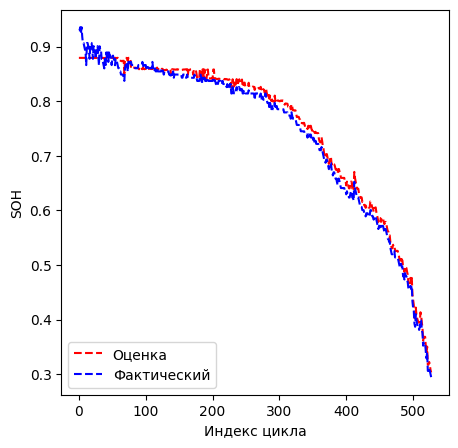

In [ ]:
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

# **Predict for top 8 features**

Соответствия features: 0 - 'Voltage(V)', 1 -'dV/dt(V/s)', 2 -'Internal_Resistance(Ohm)', 3 -'Capacity_Ah', 4 -'Energy_Wh', 5 -'Hausdorff_distance', 6 -'Frechet_distance', 7 -'Skewness', 8 -'Kurtosis', 9 -'Slope', 10 -'Charge_Time_s'

Feature rank by gradient boosting: 4, 10, 3, 5, 1, 0, 7, 6, 2, 9, 8

In [ ]:
top_8 = [4, 10, 3, 5, 1, 0, 7, 6]
df_X_train_top_8 = df_X_train.drop(columns=[2, 8, 9])
X_train_top_8 = np.array(df_X_train_top_8)
df_X_train_top_8.columns

Index([0, 1, 3, 4, 5, 6, 7, 10], dtype='object')

In [ ]:
gb_top_8 = gb
gb_top_8.fit(df_X_train_top_8, y_train)
gb_top_8_mse = mean_squared_error(y_train, gb_top_8.predict(X_train_top_8), squared=False)
print(f"GB MSE for best features:{gb_top_8_mse:.15f}")

GB MSE for best features:0.042737146462341


In [ ]:
gb_top_8_gs = GridSearchCV(estimator = gb_top_8, param_grid = gb_params, cv = group_kfold, n_jobs = -1, verbose = 4)

In [ ]:
gb_top_8_gs.fit(df_X_train_top_8, y_train, groups = groups)

model_save_name = 'gb_top_8_CS.bin'
folder_path = '/content/drive/MyDrive/Battery_project/Gradient_boost'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(gb_top_8_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/Gradient_boost

Fitting 5 folds for each of 15 candidates, totalling 75 fits
cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/Gradient_boost'
pickle_file_path = os.path.join(pickle_file_folder, 'gb_top_8_CS.bin')
gb_top_8_gs = pd.read_pickle(pickle_file_path)

In [ ]:
gb_top_8_best_estimator = gb_top_8_gs.best_estimator_
gb_top_8_best_parameters = gb_top_8_gs.best_params_
gb_top_8_best_parameters

{'max_depth': 4, 'n_estimators': 100}

In [ ]:
# Проверка ошибки на кросс-валидации
# cv = KFold(n_splits=5, shuffle=True, random_state=1)
# scores = cross_val_score(estimator=gb_top_7_best_estimator, X=df_X_train_top_7, y=df_y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

Наилучший результат: 0.999
Наилучшие параметры: 
	max_depth: 4
	n_estimators: 100
Best GB MSE for train data 4.917955069852297e-06


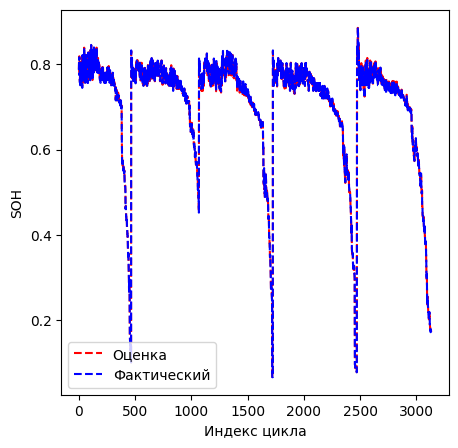

In [ ]:
# Predict for train data (predict itself)
print('Наилучший результат: %0.3f' % gb_top_8_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_top_8_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_top_8_best_parameters[param_name]))

y_pred = gb_top_8_best_estimator.predict(X_train_top_8)
print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))

# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_train, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

In [ ]:
df_X_test_top_8 = df_X_test.drop(columns=[2, 8, 9])
X_test_top_8 = np.array(df_X_test_top_8)

In [ ]:
# Predict for test data (cleaned)
y_pred = gb_top_8_best_estimator.predict(X_test_top_8)
print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))

Best GB MSE for test data 0.00020718933877610692


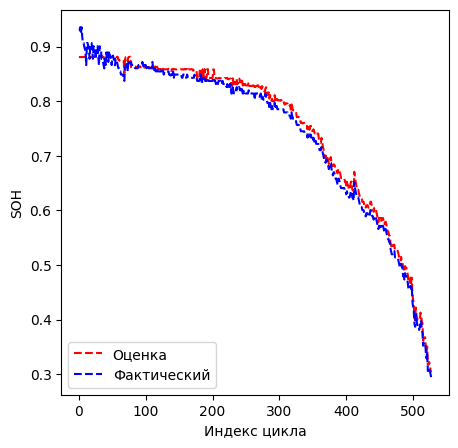

In [ ]:
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

# **Predict for top 3 features**

Соответствия features: 0 - 'Voltage(V)', 1 -'dV/dt(V/s)', 2 -'Internal_Resistance(Ohm)', 3 -'Capacity_Ah', 4 -'Energy_Wh', 5 -'Hausdorff_distance', 6 -'Frechet_distance', 7 -'Skewness', 8 -'Kurtosis', 9 -'Slope', 10 -'Charge_Time_s'

Feature rank by gradient boosting: 4, 10, 3, 5, 1, 0, 7, 6, 2, 9, 8

In [ ]:
top_3 = [4, 3, 10]
df_X_train_top_3 = df_X_train.drop(columns=[2, 8, 9, 5, 1, 0, 7, 6])
X_train_top_3 = np.array(df_X_train_top_3)
df_X_train_top_3.columns

Index([3, 4, 10], dtype='object')

In [ ]:
gb_top_3 = gb
gb_top_3.fit(df_X_train_top_3, y_train)
gb_top_3_mse = mean_squared_error(y_train, gb_top_3.predict(X_train_top_3), squared=False)
print(f"GB MSE for best features:{gb_top_3_mse:.15f}")

GB MSE for best features:0.000495752866717


In [ ]:
gb_top_3_gs = GridSearchCV(estimator = gb_top_3, param_grid = gb_params, cv = group_kfold, n_jobs = -1, verbose = 4)

In [ ]:
gb_top_3_gs.fit(df_X_train_top_3, y_train, groups = groups)

model_save_name = 'gb_top_3_CS.bin'
folder_path = '/content/drive/MyDrive/Battery_project/Gradient_boost'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(gb_top_3_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/Gradient_boost

Fitting 5 folds for each of 15 candidates, totalling 75 fits
cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/Gradient_boost'
pickle_file_path = os.path.join(pickle_file_folder, 'gb_top_3_CS.bin')
gb_top_3_gs = pd.read_pickle(pickle_file_path)

In [ ]:
gb_top_3_best_estimator = gb_top_3_gs.best_estimator_
gb_top_3_best_parameters = gb_top_3_gs.best_params_
gb_top_3_best_parameters

{'max_depth': 4, 'n_estimators': 100}

In [ ]:
# Predict for train data (predict itself)
print('Наилучший результат: %0.3f' % gb_top_3_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_top_3_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_top_3_best_parameters[param_name]))

y_pred = gb_top_3_best_estimator.predict(X_train_top_3)
print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))

Наилучший результат: 0.998
Наилучшие параметры: 
	max_depth: 4
	n_estimators: 100
Best GB MSE for train data 5.513786474115332e-06


In [ ]:
df_X_test_top_3 = df_X_test.drop(columns=[2, 8, 9, 5, 1, 0, 7, 6])
X_test_top_3 = np.array(df_X_test_top_3)

In [ ]:
# Predict for test data (cleaned)
y_pred = gb_top_3_best_estimator.predict(X_test_top_3)
print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))

Best GB MSE for test data 0.0004330778199689467


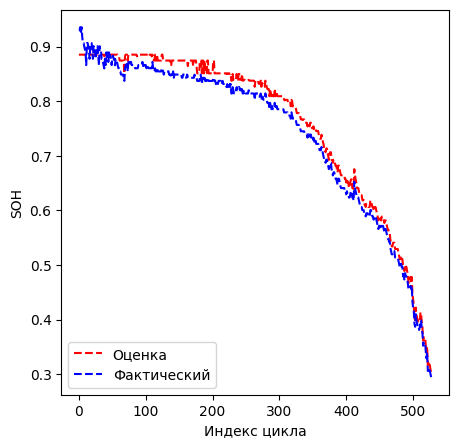

In [ ]:
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

# **Predict fot top 1 feature**

In [ ]:
top_1 = [3]
df_X_train_top_1 = df_X_train.drop(columns=[2, 8, 9, 5, 1, 0, 7, 6, 10, 4])
X_train_top_1 = np.array(df_X_train_top_1)
df_X_train_top_1.columns

Index([3], dtype='object')

In [ ]:
gb_top_1 = gb
gb_top_1.fit(df_X_train_top_1, y_train)
gb_top_1_mse = mean_squared_error(y_train, gb_top_1.predict(X_train_top_1), squared=False)
print(f"GB MSE for best features:{gb_top_1_mse:.15f}")

GB MSE for best features:0.001262283923974


In [ ]:
gb_top_1_gs = GridSearchCV(estimator = gb_top_1, param_grid = gb_params, cv = group_kfold, n_jobs = -1, verbose = 4)

In [ ]:
gb_top_1_gs.fit(df_X_train_top_1, y_train, groups = groups)

model_save_name = 'gb_top_1_CS.bin'
folder_path = '/content/drive/MyDrive/Battery_project/Gradient_boost'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(gb_top_1_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/Gradient_boost

Fitting 5 folds for each of 15 candidates, totalling 75 fits
cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/Gradient_boost'
pickle_file_path = os.path.join(pickle_file_folder, 'gb_top_1_CS.bin')
gb_top_1_gs = pd.read_pickle(pickle_file_path)

In [ ]:
gb_top_1_best_estimator = gb_top_1_gs.best_estimator_
gb_top_1_best_parameters = gb_top_1_gs.best_params_
gb_top_1_best_parameters

{'max_depth': 3, 'n_estimators': 100}

In [ ]:
# Predict for train data (predict itself)
print('Наилучший результат: %0.3f' % gb_top_1_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_top_1_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_top_1_best_parameters[param_name]))

y_pred = gb_top_1_best_estimator.predict(X_train_top_1)
print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))

Наилучший результат: 0.998
Наилучшие параметры: 
	max_depth: 3
	n_estimators: 100
Best GB MSE for train data 7.801431803482334e-06


In [ ]:
df_X_test_top_1 = df_X_test.drop(columns=[2, 8, 9, 5, 1, 0, 7, 6, 10, 4])
X_test_top_1 = np.array(df_X_test_top_1)

In [ ]:
# Predict for test data (cleaned)
y_pred = gb_top_1_best_estimator.predict(X_test_top_1)
print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))

Best GB MSE for test data 0.0004176730970827519


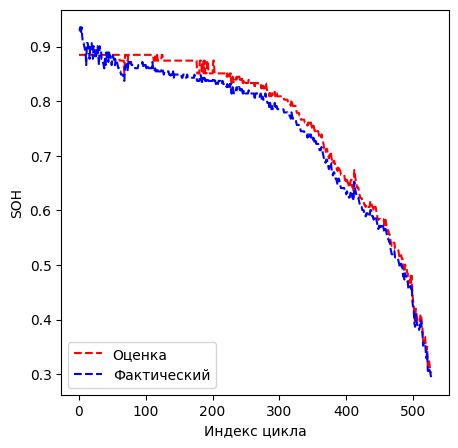

In [ ]:
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

# **Transform data to features with/without Capacity, Energy and Charge Time**

In [ ]:
#df_X_train_top_7 = df_X_train.drop(columns=[2, 6, 8, 9])
# Only for capacity
df_X_test = data_test.drop(columns=['SOH', 'Current(A)', 'Signal_mean','Cycle_Index','Group', 'Internal_Resistance(Ohm)', 'Frechet_distance', 'Slope', 'Kurtosis', 'Energy_Wh', 'Charge_Time_s'])
df_y_test = data_test['SOH']
X_test = np.array(df_X_test)
y_test = np.array(df_y_test).reshape(-1)
df_X_test.columns

Index(['Voltage(V)', 'dV/dt(V/s)', 'Capacity_Ah', 'Hausdorff_distance',
       'Skewness'],
      dtype='object')

In [ ]:
# Only for capacity
df_X_train = data_train.drop(columns=['SOH', 'Current(A)', 'Signal_mean','Cycle_Index','Group', 'Internal_Resistance(Ohm)', 'Frechet_distance', 'Slope', 'Kurtosis', 'Energy_Wh', 'Charge_Time_s'])
df_y_train = data_train['SOH']
X_train = np.array(df_X_train)
y_train = np.array(df_y_train).reshape(-1)
df_X_train.columns

Index(['Voltage(V)', 'dV/dt(V/s)', 'Capacity_Ah', 'Hausdorff_distance',
       'Skewness'],
      dtype='object')

In [ ]:
# Only for energy
df_X_test = data_test.drop(columns=['SOH', 'Current(A)', 'Signal_mean','Cycle_Index','Group', 'Internal_Resistance(Ohm)', 'Frechet_distance', 'Slope', 'Kurtosis', 'Capacity_Ah', 'Charge_Time_s'])
df_y_test = data_test['SOH']
X_test = np.array(df_X_test)
y_test = np.array(df_y_test).reshape(-1)
df_X_test.columns

Index(['Voltage(V)', 'dV/dt(V/s)', 'Energy_Wh', 'Hausdorff_distance',
       'Skewness'],
      dtype='object')

In [ ]:
# Only for energy
df_X_train = data_train.drop(columns=['SOH', 'Current(A)', 'Signal_mean','Cycle_Index','Group', 'Internal_Resistance(Ohm)', 'Frechet_distance', 'Slope', 'Kurtosis', 'Capacity_Ah', 'Charge_Time_s'])
df_y_train = data_train['SOH']
X_train = np.array(df_X_train)
y_train = np.array(df_y_train).reshape(-1)
df_X_train.columns

Index(['Voltage(V)', 'dV/dt(V/s)', 'Energy_Wh', 'Hausdorff_distance',
       'Skewness'],
      dtype='object')

In [ ]:
# Only for charge time
df_X_test = data_test.drop(columns=['SOH', 'Current(A)', 'Signal_mean','Cycle_Index','Group', 'Internal_Resistance(Ohm)', 'Frechet_distance', 'Slope', 'Kurtosis', 'Capacity_Ah', 'Energy_Wh'])
df_y_test = data_test['SOH']
X_test = np.array(df_X_test)
y_test = np.array(df_y_test).reshape(-1)
df_X_test.columns

Index(['Voltage(V)', 'dV/dt(V/s)', 'Hausdorff_distance', 'Skewness',
       'Charge_Time_s'],
      dtype='object')

In [ ]:
# Only for charge time
df_X_train = data_train.drop(columns=['SOH', 'Current(A)', 'Signal_mean','Cycle_Index','Group', 'Internal_Resistance(Ohm)', 'Frechet_distance', 'Slope', 'Kurtosis', 'Capacity_Ah', 'Energy_Wh'])
df_y_train = data_train['SOH']
X_train = np.array(df_X_train)
y_train = np.array(df_y_train).reshape(-1)
df_X_train.columns

Index(['Voltage(V)', 'dV/dt(V/s)', 'Hausdorff_distance', 'Skewness',
       'Charge_Time_s'],
      dtype='object')

# **Refit GB on new data with/without Capacity, Energy, Charge time**

In [ ]:
gb_params = {'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],
    'n_estimators': [10, 100, 200]}

In [ ]:
# Evaluate model score by cross-validation
no_of_splits = len(np.unique(data_train.Group))
groups = data_train.Group
group_kfold = GroupKFold(n_splits=no_of_splits)
no_of_splits

5

In [ ]:
gb_gs_data_only_cap = GridSearchCV(estimator = gb, param_grid = gb_params, cv = group_kfold, n_jobs = -1, verbose = 4)

In [ ]:
gb_gs_data_only_cap.fit(X_train, y_train, groups = groups)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=GradientBoostingRegressor(max_depth=10), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],
                         'n_estimators': [10, 100, 200]},
             verbose=4)

In [ ]:
gb_gs_data_only_ener= GridSearchCV(estimator = gb, param_grid = gb_params, cv = group_kfold, n_jobs = -1, verbose = 4)
gb_gs_data_only_ener.fit(X_train, y_train, groups = groups)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=GradientBoostingRegressor(max_depth=10), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],
                         'n_estimators': [10, 100, 200]},
             verbose=4)

In [ ]:
gb_gs_data_only_time= GridSearchCV(estimator = gb, param_grid = gb_params, cv = group_kfold, n_jobs = -1, verbose = 4)
gb_gs_data_only_time.fit(X_train, y_train, groups = groups)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=GradientBoostingRegressor(max_depth=10), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],
                         'n_estimators': [10, 100, 200]},
             verbose=4)

Best GB MSE for train data 5.269695308647677e-06


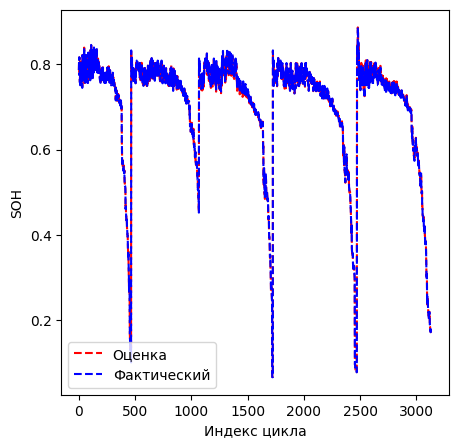

In [ ]:
y_pred = gb_gs_data_only_cap.best_estimator_.predict(X_train)
print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))
# Visualize y_pred and y_train
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_train, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

Best GB MSE for train data 4.545992698868186e-06


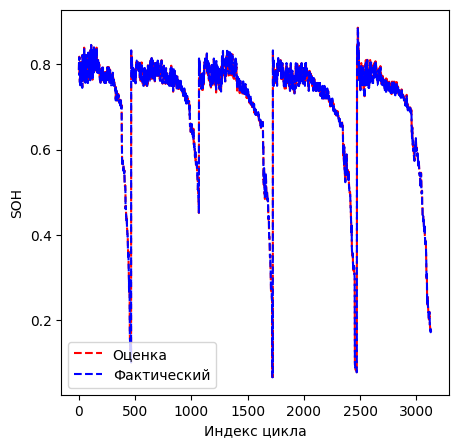

In [ ]:
y_pred = gb_gs_data_only_ener.best_estimator_.predict(X_train)
print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))
# Visualize y_pred and y_train
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_train, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

Best GB MSE for train data 5.938714789707326e-06


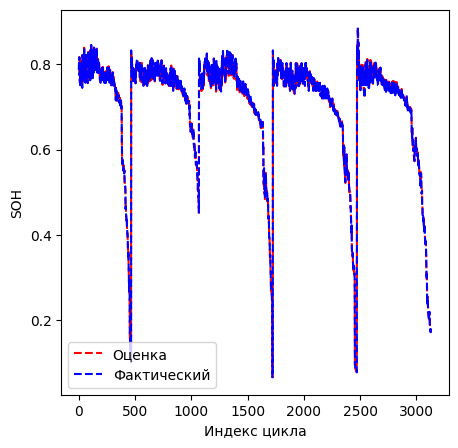

In [ ]:
y_pred = gb_gs_data_only_time.best_estimator_.predict(X_train)
print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))
# Visualize y_pred and y_train
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_train, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

Best GB MSE for test data 0.00022059441030353904


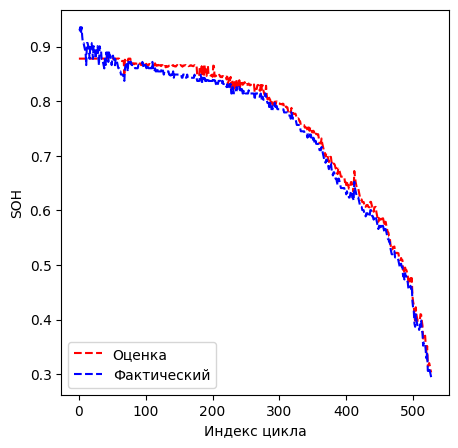

In [ ]:
y_pred = gb_gs_data_only_cap.best_estimator_.predict(X_test)
print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

Best GB MSE for test data 0.0002503979188405137


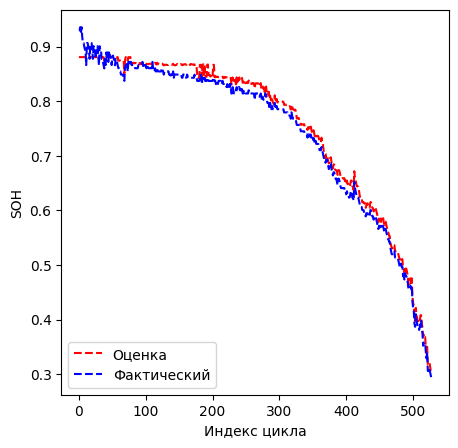

In [ ]:
y_pred = gb_gs_data_only_ener.best_estimator_.predict(X_test)
print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

Best GB MSE for test data 0.00028835566946580887


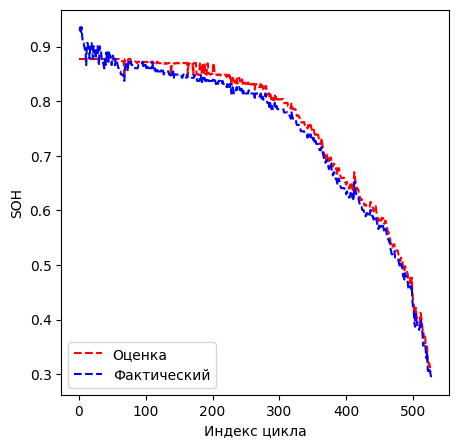

In [ ]:
y_pred = gb_gs_data_only_time.best_estimator_.predict(X_test)
print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))
# Visualize y_pred and y_test
plt.figure(figsize=[5,5])
plt.ylabel('SOH')
plt.xlabel('Индекс цикла')
plt.plot(y_pred, 'r--', label='Оценка')
plt.plot(y_test, 'b--', label='Фактический')
plt.legend(loc="lower left")
plt.show()

# **CX_batteries**

In [ ]:
data_fs = pd.DataFrame()
n = 1
for file in range(len(fs_filenames_CX)):
  data = pd.read_csv(os.path.join(filenames_folder, fs_filenames_CX[file]), index_col=None)
  data = data.assign(Group=n)
  data_fs = pd.concat([data_fs, data], axis=0)
  n+=1
data_fs.columns

Index(['Cycle_Index', 'Current(A)', 'Voltage(V)', 'dV/dt(V/s)',
       'Internal_Resistance(Ohm)', 'Capacity_Ah', 'Energy_Wh',
       'Hausdorff_distance', 'Frechet_distance', 'Signal_mean', 'Skewness',
       'Kurtosis', 'Slope', 'Charge_Time_s', 'SOH', 'Group'],
      dtype='object')

In [ ]:
df_X_fs = data_fs.drop(columns=['SOH', 'Cycle_Index', 'Group'])
df_y_fs = data_fs['SOH']
X_fs = np.array(df_X_fs)
y_fs = np.array(df_y_fs).reshape(-1)
df_X_fs.columns

Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)',
       'Capacity_Ah', 'Energy_Wh', 'Hausdorff_distance', 'Frechet_distance',
       'Signal_mean', 'Skewness', 'Kurtosis', 'Slope', 'Charge_Time_s'],
      dtype='object')

In [ ]:
df_X_fs = df_X_fs.rename(columns={'Charge_Time_s': 'Время заряда (с)', 'Slope': 'Наклон напряжения', 'Kurtosis': 'Эксцесс напряжения', 'Skewness': 'Асимметрия напряжения',\
        'Frechet_distance': 'Расстояние Фреше', 'Hausdorff_distance': 'Расстояние Хаусдорффа', 'Energy_Wh' : 'Энергия (Вт*ч)', 'Capacity_Ah': 'Емкость (А*ч)',\
        'Internal_Resistance(Ohm)': 'Внутренее сопротивление (Ом)', 'dV/dt(V/s)': 'Производная напряжения (В/с)', 'Voltage(V)': 'Напряжение (В)', 'Current(A)': 'Ток (А)',  'Signal_mean': 'Средний ток (А)'})

In [ ]:
df_X_fs.columns

Index(['Ток (А)', 'Напряжение (В)', 'Производная напряжения (В/с)',
       'Внутренее сопротивление (Ом)', 'Емкость (А*ч)', 'Энергия (Вт*ч)',
       'Расстояние Хаусдорффа', 'Расстояние Фреше', 'Средний ток (А)',
       'Асимметрия напряжения', 'Эксцесс напряжения', 'Наклон напряжения',
       'Время заряда (с)'],
      dtype='object')

# **RF**

In [ ]:
rf = RandomForestRegressor(n_estimators=300, bootstrap=True, n_jobs=None)

In [ ]:
param_space = {"max_depth": [5, 10, 15, 20, 25],  # 15-25, 5-10
                   "max_features": [2, 3, 4, 5, 6],
                   "min_samples_split": [2, 3, 4, 5],
                   "min_samples_leaf": [5, 7, 10, 12, 15],
                   "criterion": ['squared_error']}

In [ ]:
# Evaluate model score by cross-validation
no_of_splits = len(np.unique(data_fs.Group))
groups = data_fs.Group
group_kfold = GroupKFold(n_splits=no_of_splits)
no_of_splits

3

In [ ]:
rf_gs = GridSearchCV(estimator=rf, param_grid=param_space, cv=group_kfold, n_jobs=-1, verbose=2, refit=True)

NameError: name 'rf' is not defined

In [ ]:
rf_gs.fit(X_fs, y_fs, groups=groups)

model_save_name = 'rf_for_RFECV_gs_new_CX.bin'
folder_path = '/content/drive/MyDrive/Battery_project/RF_for_RFECV_CC_step'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(rf_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/RF_for_RFECV_СС_step

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/RF_for_RFECV_CC_step'
pickle_file_path = os.path.join(pickle_file_folder, 'rf_for_RFECV_gs_new_CX.bin')
rf_gs = pd.read_pickle(pickle_file_path)

In [ ]:
rf_best_estimator = rf_gs.best_estimator_
print(rf_best_estimator)
print(rf_gs.best_score_)
print(rf_best_estimator.feature_importances_)

RandomForestRegressor(max_depth=15, max_features=6, min_samples_leaf=15,
                      min_samples_split=4, n_estimators=300)
-17.33440114899249
[0.2823772  0.05986463 0.00200471 0.11077757 0.04011986 0.02809594
 0.01972606 0.00105083 0.27263831 0.11247927 0.0170017  0.01031274
 0.04355117]


<Axes: >

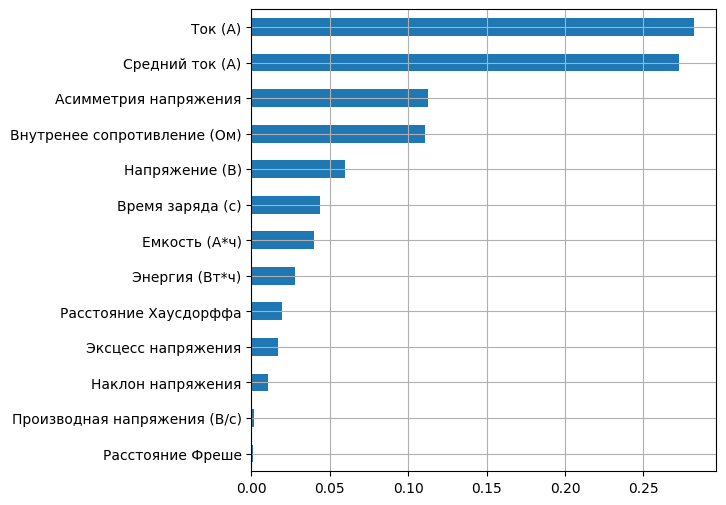

In [ ]:
# Проверка ошибки на кросс-валидации и feature_importances
# cv = KFold(n_splits=5, shuffle=True, random_state=1)
# scores = cross_val_score(estimator=rf_best_estimator, X=X_fs, y=y_fs, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

pd.DataFrame(data={'score': rf_best_estimator.feature_importances_},
                      index=df_X_fs.columns).sort_values(by='score').plot(kind='barh', grid=True, figsize=(6,6), legend=False)

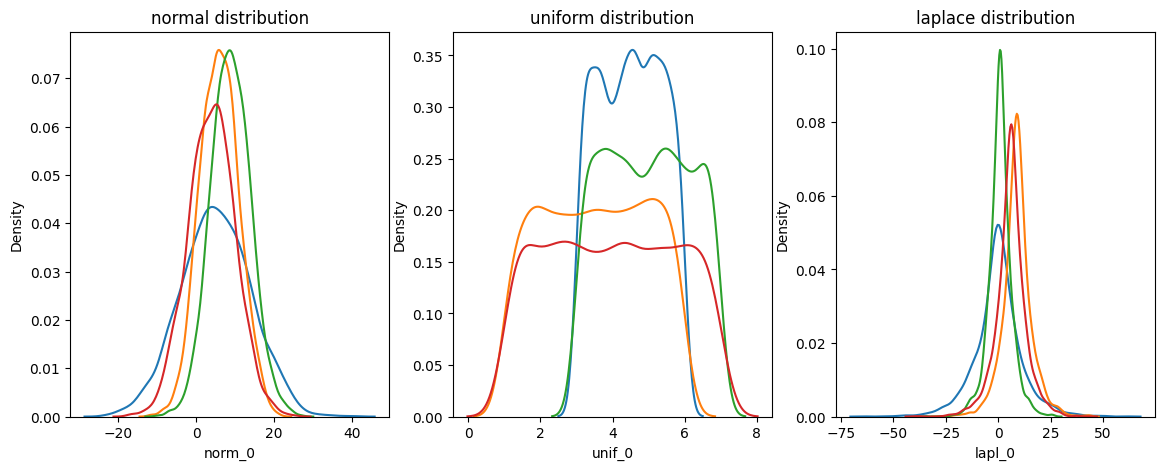

In [ ]:
# Для проверки того, что rf не переобучен, сделаем зашумленные данные:
# Создадим 12 шумовых признаков, элементами которых будут некоррелируемые случайные числа из выборок с нормальным, равномерным и Лапласовым распределениями.
# Параметры каждого распределения подбираются случайным образом независимо друг от друга.
# Далее также построим оценку кросс-валидации на этих данных и feature_importances
# утановим значение генератора случайных чисел для воспроизводимости
np.random.seed(1)

fix, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
ax1.set_title("normal distribution")
ax2.set_title("uniform distribution")
ax3.set_title("laplace distribution")
for i in range(4):
    df_X_fs.loc[:, f'norm_{i}'] = np.random.normal(loc=np.random.randint(low=0, high=10),
                                             scale=np.random.randint(low=1, high=10),
                                             size=(df_X_fs.shape[0], 1))

    df_X_fs.loc[:, f'unif_{i}'] = np.random.uniform(low=np.random.randint(low=1, high=4),
                                              high=np.random.randint(low=5, high=10),
                                              size=(df_X_fs.shape[0], 1))
    df_X_fs.loc[:, f'lapl_{i}'] = np.random.laplace(loc=np.random.randint(low=0, high=10),
                                              scale=np.random.randint(low=1, high=10),
                                              size=(df_X_fs.shape[0], 1))
    # визуализируем распределения признаков
    sns.kdeplot(df_X_fs[f'norm_{i}'], ax=ax1)
    sns.kdeplot(df_X_fs[f'unif_{i}'], ax=ax2)
    sns.kdeplot(df_X_fs[f'lapl_{i}'], ax=ax3)

In [ ]:
# Преобучение RF на зашумленных данных
rf_noise_data = rf_best_estimator.fit(df_X_fs, df_y_fs)

model_save_name = 'rf_for_RFECV_noise_data_new_CX.bin'
folder_path = '/content/drive/MyDrive/Battery_project/RF_for_RFECV_CC_step'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(rf_noise_data, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/RF_for_RFECV_СС_step

cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/RF_for_RFECV_CC_step'
pickle_file_path = os.path.join(pickle_file_folder, 'rf_for_RFECV_noise_data_new_CX.bin')
rf_noise_data = pd.read_pickle(pickle_file_path)

In [ ]:
rf_noise_data.feature_importances_

array([2.55530414e-01, 4.07597579e-02, 9.83330810e-03, 1.21301689e-01,
       4.00804287e-02, 3.63071080e-02, 2.54509553e-02, 3.64165585e-03,
       2.68984630e-01, 7.70433092e-02, 4.68010843e-02, 2.53189483e-02,
       4.63715429e-02, 1.51761960e-04, 2.43952749e-04, 1.66507618e-04,
       2.18946277e-04, 1.80285711e-04, 1.87478427e-04, 2.28836260e-04,
       2.01438701e-04, 2.75151626e-04, 1.94356759e-04, 2.23105086e-04,
       3.03347422e-04])

<Axes: >

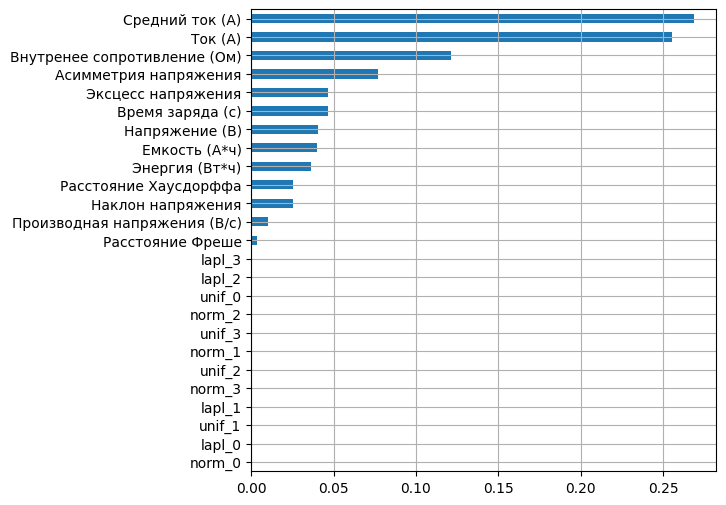

In [ ]:
# Проверка ошибки на кросс-валидации и feature_importances зашумленных данных
# cv = KFold(n_splits=5, shuffle=True, random_state=1)
# scores = cross_val_score(estimator=rf_noise_data, X=df_X_fs, y=df_y_fs, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

pd.DataFrame(data={'score': rf_noise_data.feature_importances_},
                      index=df_X_fs.columns).sort_values(by='score').plot(kind='barh', grid=True, figsize=(6,6), legend=False)

# **RFE with RF.best_estimator_**

In [ ]:
min_features_to_select = 2
rfe_cv = RFECV(estimator=rf_best_estimator, min_features_to_select=min_features_to_select, cv=group_kfold, step=1,
                   scoring='neg_mean_squared_error', verbose=2, n_jobs=None)

In [ ]:
rfe_cv.fit(X_fs, y_fs, groups=groups)

model_save_name = 'rfecv_CC_step_new_CX.bin'
folder_path = '/content/drive/MyDrive/Battery_project/RFECV_CC_step'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(rfe_cv, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/rfecv_СС_step

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/RFECV_CC_step'
pickle_file_path = os.path.join(pickle_file_folder, 'rfecv_CC_step_new_CX.bin')
rfe_cv = pd.read_pickle(pickle_file_path)

In [ ]:
# Возвращаемся к данным без шумов в df_X_fs
df_X_fs = data_fs.drop(columns=['SOH', 'Cycle_Index', 'Group'])
df_y_fs = data_fs['SOH']

All features:  Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)',
       'Capacity_Ah', 'Energy_Wh', 'Hausdorff_distance', 'Frechet_distance',
       'Signal_mean', 'Skewness', 'Kurtosis', 'Slope', 'Charge_Time_s'],
      dtype='object')
Selected features:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True]
Number of selected features:  13
Cross-validation results:  {'mean_test_score': array([-1.06806061, -1.06782044, -1.06779815, -1.06567852, -1.063488  ,
       -1.06222888, -1.06175917, -1.06212268, -1.05993072, -1.0560931 ,
       -1.05591944, -1.05494298]), 'std_test_score': array([0.03499751, 0.03474665, 0.03472018, 0.03387996, 0.03273377,
       0.03189591, 0.03176715, 0.03182876, 0.03164363, 0.02650617,
       0.02494733, 0.02382523]), 'split0_test_score': array([-1.10305812, -1.10256709, -1.10251833, -1.09955848, -1.09622177,
       -1.09412479, -1.09352632, -1.09395143, -1.09157435, -1.08259928,
       -1.08086677, -1.078

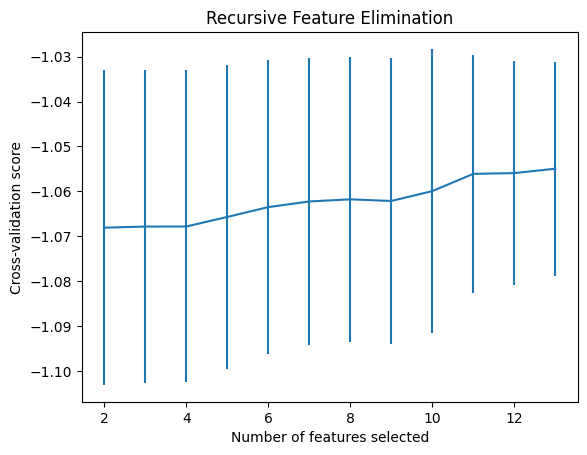

In [ ]:
print("All features: " , df_X_fs.columns)
print("Selected features: ", rfe_cv.support_)
print("Number of selected features: ", rfe_cv.n_features_)
print("Cross-validation results: ", rfe_cv.cv_results_)
# List of features
for i in range(X_fs.shape[1]):
  print(f'Column: {i}, Selected {rfe_cv.support_[i]}, Rank: {rfe_cv.ranking_[i]}')
# Plot
n_scores = len(rfe_cv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfe_cv.cv_results_["mean_test_score"],
    yerr=rfe_cv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()
# Чем более отрицательный score, тем лучше, так как score - neg_mean_squared_error

# **Select features with SelectKBest**

In [ ]:
# Возвращаемся к данным без шумов
df_X_fs = data_fs.drop(columns=['SOH', 'Cycle_Index', 'Group'])
df_y_fs = data_fs['SOH']
X_fs = np.array(df_X_fs)
y_fs = np.array(df_y_fs).reshape(-1)
df_X_fs.columns

Index(['Current(A)', 'Voltage(V)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)',
       'Capacity_Ah', 'Energy_Wh', 'Hausdorff_distance', 'Frechet_distance',
       'Signal_mean', 'Skewness', 'Kurtosis', 'Slope', 'Charge_Time_s'],
      dtype='object')

In [ ]:
select_k_best = GenericUnivariateSelect(score_func=mutual_info_regression, mode = 'k_best', param = 'all')
select_k_best.fit(X_fs, y_fs)
# выведем результаты оценки каждого признака
pd.DataFrame(data={'score':select_k_best.scores_,
                   'support':select_k_best.get_support()},
             index=df_X_fs.columns).sort_values(by='score',ascending=False)

,score,support
Capacity_Ah,5.626581,True
Energy_Wh,4.474793,True
Charge_Time_s,4.198361,True
Hausdorff_distance,2.519724,True
Skewness,2.476649,True
Slope,2.097842,True
Voltage(V),1.868681,True
Kurtosis,1.709479,True
dV/dt(V/s),1.461680,True
Current(A),1.369514,True


# **Transform data for a prediction model according to the features selected**

In [ ]:
data_test = pd.DataFrame()
n = 1
for file in range(len(test_filenames_CX)):
  data = pd.read_csv(os.path.join(filenames_folder, test_filenames_CX[file]), index_col=None)
  data = data.assign(Group=n).dropna()
  data_test = pd.concat([data_test, data], axis=0)
  n+=1
# data_test.columns

In [ ]:
groups_data_test = len(data_test.Group.unique())
groups_data_test

1

In [ ]:
df_X_test = data_test.drop(columns=['SOH'])
df_y_test = data_test['SOH']
X_test = np.array(df_X_test)
y_test = np.array(df_y_test).reshape(-1)

In [ ]:
data_train = pd.DataFrame()
n = 1
for file in range(len(train_filenames_CX)):
  data = pd.read_csv(os.path.join(filenames_folder, train_filenames_CX[file]), index_col=None)
  data = data.assign(Group=n).dropna()
  data_train = pd.concat([data_train, data], axis=0)
  n+=1
# data_train.columns

In [ ]:
groups_data_train = len(data_train.Group.unique())
groups_data_train

4

In [ ]:
df_X_train = data_train.drop(columns=['SOH'])
df_y_train = data_train['SOH']
X_train = np.array(df_X_train)
y_train = np.array(df_y_train).reshape(-1)

# **Make prediction with Gradient Boost**

In [ ]:
gb = GradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=1
)

In [ ]:
gb.fit(X_train, y_train)
gb_mse = mean_squared_error(y_train, gb.predict(X_train), squared=False)
print(f"GB MSE:{gb_mse:.15f}")

GB MSE:0.310693173017644


In [ ]:
gb.score(X_test, y_test) # R2 score

-0.5917125869051052

In [ ]:
gb_params = {'max_depth': [1, 2, 3, 4, 5],
    'n_estimators': [10, 100, 200]}

In [ ]:
# Evaluate model score by cross-validation
no_of_splits = len(np.unique(data_train.Group))
groups = data_train.Group
group_kfold = GroupKFold(n_splits=no_of_splits)
no_of_splits

4

In [ ]:
gb_gs = GridSearchCV(estimator = gb, param_grid = gb_params, cv = group_kfold, n_jobs = -1, verbose = 4)

In [ ]:
gb_gs.fit(X_train, y_train, groups = groups)

model_save_name = 'gb_new_CX.bin'
folder_path = '/content/drive/MyDrive/Battery_project/Gradient_boost'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(gb_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/Gradient_boost

Fitting 4 folds for each of 15 candidates, totalling 60 fits
cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/Gradient_boost'
pickle_file_path = os.path.join(pickle_file_folder, 'gb_new_CX.bin')
gb_gs = pd.read_pickle(pickle_file_path)

In [ ]:
gb_best_estimator = gb_gs.best_estimator_
gb_best_parameters = gb_gs.best_params_

scores = [-0.13319418 -0.13290656 -0.12630612 -0.14846284 -0.12733234] 
mean score = -0.13364 +/- 0.00792


<Axes: >

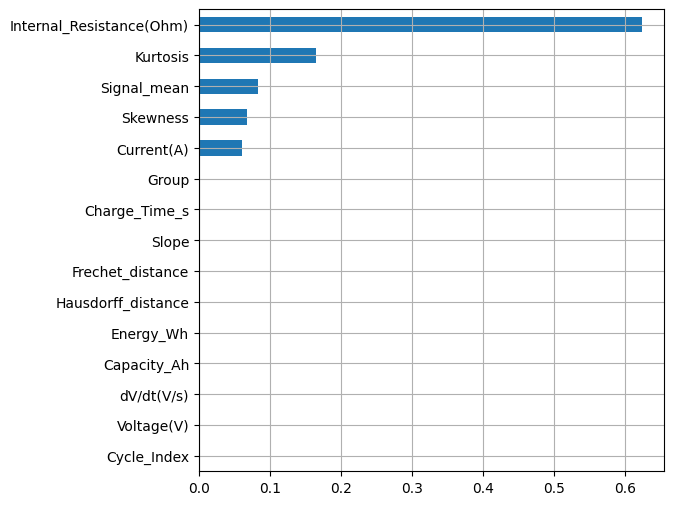

In [ ]:
# Проверка ошибки на кросс-валидации и feature_importances
cv = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(estimator=gb_best_estimator, X=df_X_train, y=df_y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

pd.DataFrame(data={'score': gb_best_estimator.feature_importances_},
                      index=df_X_train.columns).sort_values(by='score').plot(kind='barh', grid=True, figsize=(6,6), legend=False)

In [ ]:
print('Наилучший результат: %0.3f' % gb_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_best_parameters[param_name]))

y_pred = gb_best_estimator.predict(X_train)

print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))

Наилучший результат: -24.529
Наилучшие параметры: 
	max_depth: 1
	n_estimators: 10
Best GB MSE for train data 0.13309182210815554


In [ ]:
gb_best_estimator = gb_gs.best_estimator_
gb_best_parameters = gb_gs.best_params_
print('Наилучший результат: %0.3f' % gb_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_best_parameters[param_name]))

y_pred = gb_best_estimator.predict(X_test)

print('Best GB MSE for test data ' + str(mean_squared_error(y_test, y_pred)))

Наилучший результат: -24.529
Наилучшие параметры: 
	max_depth: 1
	n_estimators: 10
Best GB MSE for test data 0.07013961802423019


In [ ]:
samples = range(20)
X_test_samples = [X_test[i] for i in samples]
y_test_samples = [y_test[i] for i in samples]
y_pred_samples = gb_best_estimator.predict(X_test_samples)

# print(len(y_test_samples), len(y_pred_samples))
a = [(y_pred_samples[i], y_test_samples[i], abs(y_pred_samples[i]-y_test_samples[i])) for i in range(len(samples))]
b = sorted(a, key=lambda x: x[2], reverse=True)
for i in range(20):
  print(b[i])
# for i in range(len(y_pred_samples)):
#   # print(y_test_samples[i], y_pred_samples[i])
#   print(f'{y_test_samples[i]:.3f}', f'{y_pred_samples[i]:.3f}')

(0.7961295253283246, 0.8431491355123414, 0.04701961018401679)
(0.7961295253283246, 0.8431215953235761, 0.04699206999525152)
(0.8366429989550227, 0.8677248484488335, 0.031081849493810765)
(0.8879444549606273, 0.8675764153412897, 0.02036803961933764)
(0.8879444549606273, 0.8675782934396109, 0.020366161521016446)
(0.8879444549606273, 0.8677121891280798, 0.020232265832547558)
(0.8366429989550227, 0.8554725882415568, 0.01882958928653411)
(0.8366429989550227, 0.8554441997322169, 0.01880120077719416)
(0.8366429989550227, 0.8552645582589422, 0.01862155930391951)
(0.8879444549606273, 0.873705802093734, 0.014238652866893298)
(0.8879444549606273, 0.8738614775989327, 0.014082977361694615)
(0.8879444549606273, 0.8738811699938868, 0.014063284966740586)
(0.8879444549606273, 0.8738928156548278, 0.014051639305799557)
(0.8879444549606273, 0.8738958650686456, 0.014048589891981766)
(0.8366429989550227, 0.8492951497328373, 0.012652150777814564)
(0.8879444549606273, 0.8923116693792741, 0.0043672144186467365

In [ ]:
data_new = pd.DataFrame()
n = 1
for file in range(len(test_filenames_CS)):
  data = pd.read_csv(os.path.join(filenames_folder, test_filenames_CS[file]), index_col=None)
  data = data.assign(Group=n).dropna()
  data_new = pd.concat([data_new, data], axis=0)
  n+=1
# data_new.columns

In [ ]:
df_X_new = data_new.drop(columns=['SOH'])
df_y_new = data_new['SOH']
X_new = np.array(df_X_new)
y_new= np.array(df_y_new).reshape(-1)

In [ ]:
gb_best_estimator = gb_gs.best_estimator_
gb_best_parameters = gb_gs.best_params_
print('Наилучший результат: %0.3f' % gb_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_best_parameters[param_name]))

y_pred = gb_best_estimator.predict(X_new)

print('Best GB MSE for new battery data ' + str(mean_squared_error(y_new, y_pred)))

Наилучший результат: -24.529
Наилучшие параметры: 
	max_depth: 1
	n_estimators: 10
Best GB MSE for new battery data 0.17077445327309626


# **Predict only for best 5 features**

In [ ]:
best_features = [4, 10, 3, 5, 1, 0, 7, 9]
df_X_train_best_features = df_X_train.drop(columns=[2, 6, 8])
X_train_best_features = np.array(df_X_train_best_features)
df_X_train_best_features.columns

Index([0, 1, 3, 4, 5, 8, 10], dtype='object')

In [ ]:
gb_best_features = gb
gb_best_features.fit(X_train_best_features, y_train)
gb_best_features_mse = mean_squared_error(y_train, gb_best_features.predict(X_train_best_features), squared=False)
print(f"GB MSE for best features:{gb_best_features_mse:.15f}")

GB MSE for best features:0.044954730263475


In [ ]:
# gb_params = {'max_depth': [1, 2, 3, 4, 5],
#     'n_estimators': [10, 100, 200],
#     "min_samples_split": [1, 2, 3, 4],
#     "learning_rate": [0.1],
#     "loss": ["squared_error"]}

gb_best_features_params = {'max_depth': [1, 2, 3, 4, 5],
'n_estimators': [10, 100, 200]}

In [ ]:
no_of_splits = groups_data_train
groups = data_train.Group
group_kfold = GroupKFold(n_splits=no_of_splits)

In [ ]:
gb_best_features_gs = GridSearchCV(estimator = gb_best_features, param_grid = gb_best_features_params, cv = group_kfold, n_jobs = -1, verbose = 4)

In [ ]:
gb_best_features_gs.fit(X_train_best_features, y_train, groups = groups)

model_save_name = 'gb_for_best_features_new_CS.bin'
folder_path = '/content/drive/MyDrive/Battery_project/Gradient_boost'
model_path = os.path.join(folder_path, model_save_name)
pickle.dump(gb_best_features_gs, open(model_path, 'wb'))
# save pipe.pkl to output data folder
!cp model_save_name /content/drive/MyDrive/Battery_project/Gradient_boost

Fitting 4 folds for each of 15 candidates, totalling 60 fits
cp: cannot stat 'model_save_name': No such file or directory


In [ ]:
pickle_file_folder = '/content/drive/MyDrive/Battery_project/Gradient_boost'
pickle_file_path = os.path.join(pickle_file_folder, 'gb_for_best_features_new_CS.bin')
gb_best_features_gs = pd.read_pickle(pickle_file_path)

In [ ]:
gb_best_features_best_estimator = gb_best_features_gs.best_estimator_
gb_best_features_best_parameters = gb_best_features_gs.best_params_
gb_best_features_best_estimator.feature_importances_

array([4.29876023e-05, 2.31150345e-03, 3.12803063e-04, 3.42682058e-01,
       6.49706272e-01, 3.70516797e-03, 1.23920745e-03])

scores = [-3.23472855e-06 -2.52952860e-06 -2.40848144e-06 -2.42116272e-06
 -2.60859109e-06] 
mean score = -0.00000 +/- 0.00000


<Axes: >

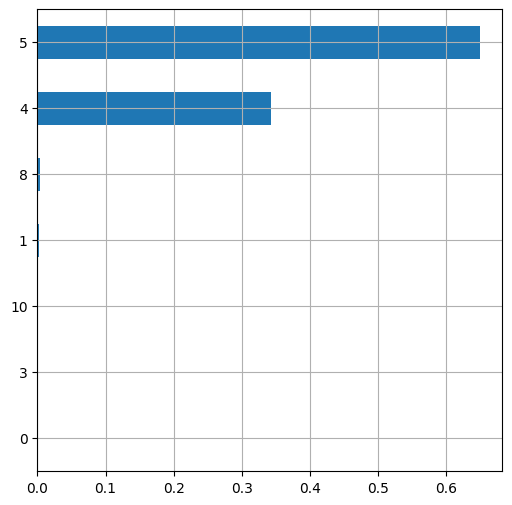

In [ ]:
# Проверка ошибки на кросс-валидации и feature_importances
cv = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(estimator=gb_best_features_best_estimator, X=df_X_train_best_features, y=df_y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

pd.DataFrame(data={'score': gb_best_features_best_estimator.feature_importances_},
                      index=df_X_train_best_features.columns).sort_values(by='score').plot(kind='barh', grid=True, figsize=(6,6), legend=False)

In [ ]:
print('Наилучший результат: %0.3f' % gb_best_features_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_best_features_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_best_features_best_parameters[param_name]))

y_pred = gb_best_features_best_estimator.predict(X_train_best_features)

print('Best GB MSE for train data ' + str(mean_squared_error(y_train, y_pred)))

Наилучший результат: 0.998
Наилучшие параметры: 
	max_depth: 5
	n_estimators: 100
Best GB MSE for train data 6.926074878378837e-07


In [ ]:
df_X_test_best_features = df_X_test.drop(columns=[2, 6, 9, 11, 7])
X_test_best_features = np.array(df_X_test_best_features)
df_X_test_best_features.columns

Index([0, 1, 3, 4, 5, 8, 10], dtype='object')

In [ ]:
print('Наилучший результат: %0.3f' % gb_best_features_gs.best_score_)
print('Наилучшие параметры: ')
for param_name in sorted(gb_best_features_best_parameters.keys()):
    print("\t%s: %r" % (param_name, gb_best_features_best_parameters[param_name]))

y_pred = gb_best_features_best_estimator.predict(X_test_best_features)

print('Best GB MSE for train data ' + str(mean_squared_error(y_test, y_pred)))

Наилучший результат: 0.998
Наилучшие параметры: 
	max_depth: 5
	n_estimators: 100
Best GB MSE for train data 0.00013367429495394646


In [ ]:
samples = range(20)
X_test_best_features_samples = [X_test_best_features[i] for i in samples]
y_test_samples = [y_test[i] for i in samples]
y_pred_samples = gb_best_features_best_estimator.predict(X_test_best_features_samples)

# print(len(y_test_samples), len(y_pred_samples))
a = [(y_pred_samples[i], y_test_samples[i], abs(y_pred_samples[i]-y_test_samples[i])) for i in range(len(samples))]
b = sorted(a, key=lambda x: x[2], reverse=True)
for i in range(20):
  print(b[i])
# for i in range(len(y_pred_samples)):
#   # print(y_test_samples[i], y_pred_samples[i])
#   print(f'{y_test_samples[i]:.3f}', f'{y_pred_samples[i]:.3f}')

(0.8722811186442035, 0.9354795123538668, 0.06319839370966329)
(0.8722811186442035, 0.9354560622201594, 0.06317494357595588)
(0.8722811186442035, 0.9296744283994826, 0.05739330975527901)
(0.8740615009848075, 0.9295937535702308, 0.05553225258542327)
(0.8722811186442035, 0.9238964713885284, 0.05161535274432483)
(0.8722811186442035, 0.9180602468100528, 0.04577912816584928)
(0.8722811186442035, 0.9066160633146004, 0.03433494467039688)
(0.8722811186442035, 0.9066125275746312, 0.03433140893042763)
(0.8722811186442035, 0.9065982642179254, 0.0343171455737219)
(0.8722811186442035, 0.9065871747203412, 0.03430605607613768)
(0.8722811186442035, 0.9065095430326175, 0.034228424388414)
(0.8722811186442035, 0.9064751086464092, 0.03419399000220569)
(0.8722811186442035, 0.9008631338750244, 0.028582015230820823)
(0.8722811186442035, 0.900862290648444, 0.028581172004240485)
(0.8722811186442035, 0.9007175754266952, 0.028436456782491626)
(0.8722811186442035, 0.894960139379498, 0.022679020735294486)
(0.872281

# **Дополнительно - генерация новых features**

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction.feature_calculators import fft_aggregated
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
# Генерация фич c помощью встроенной библиотеки, объединение с моими фичами и переобучение RF для нового датасета
# чтение файлов и присвоение номера группы каждому файлу
result_df_fs = pd.DataFrame()
for file in range(len(fs_filenames)):
  data_with_new_features = pd.DataFrame()
  data = pd.read_csv(os.path.join(filenames_folder, fs_filenames[file]), index_col=None)
  voltage = np.array(data['Voltage(V)'])
  current = np.array(data['Current(A)'])
  X_exp = np.concatenate((voltage, current), axis=0)
  extraction_settings = ComprehensiveFCParameters()
  extractor = TSFreshFeatureExtractor(show_warnings=False, n_jobs=12, default_fc_parameters=ComprehensiveFCParameters())
  X_features = extractor.fit_transform(X_exp)
  data_with_new_features = pd.concat([data, X_features], axis=1)
  result_df_fs = pd.concat([result_df_fs, data_with_new_features], axis=0)
# result_df_fs_name = os.path.join('/content/drive/MyDrive/Battery_project/new_features', 'df_with_new_features.csv')
# result_df_fs.to_csv(result_df_fs_name)

In [ ]:
result_df_fs.dropna()
df_X_fs_new = result_df_fs.drop(columns=['SOH', 'Cycle_Index', 'Unnamed: 0', 'Group'])
df_y_fs_new = result_df_fs['SOH']
X_fs_new = np.array(df_X_fs_new)
y_fs_new = np.array(df_y_fs_new).reshape(-1)

In [ ]:
rf_regressor_new = RandomForestRegressor(n_estimators=300, bootstrap=True, n_jobs=None)

In [ ]:
no_of_splits_new = len(np.unique(result_df_fs.Group))
groups_new = result_df_fs.Group
group_kfold_new = GroupKFold(n_splits=no_of_splits_new)

In [ ]:
rf_regressor_random_new = GridSearchCV(estimator=rf_regressor_new, param_grid=param_space, cv=group_kfold_new, n_jobs=-1, verbose=2, refit=True, error_score='raise')

In [ ]:
rf_regressor_random_new.fit(X_fs_new, y_fs_new, groups=groups_new)

In [ ]:
print(X_fs_new.shape)
print(y_fs_new.shape)
print(groups_new.shape)

In [ ]:
print(rf_regressor_random_new.best_estimator_)
print(rf_regressor_random_new.best_score_)
print(rf_regressor_random_new.feature_importances_)